Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [2]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks_complex.grammar import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Unconditional grammar outputs look like this:

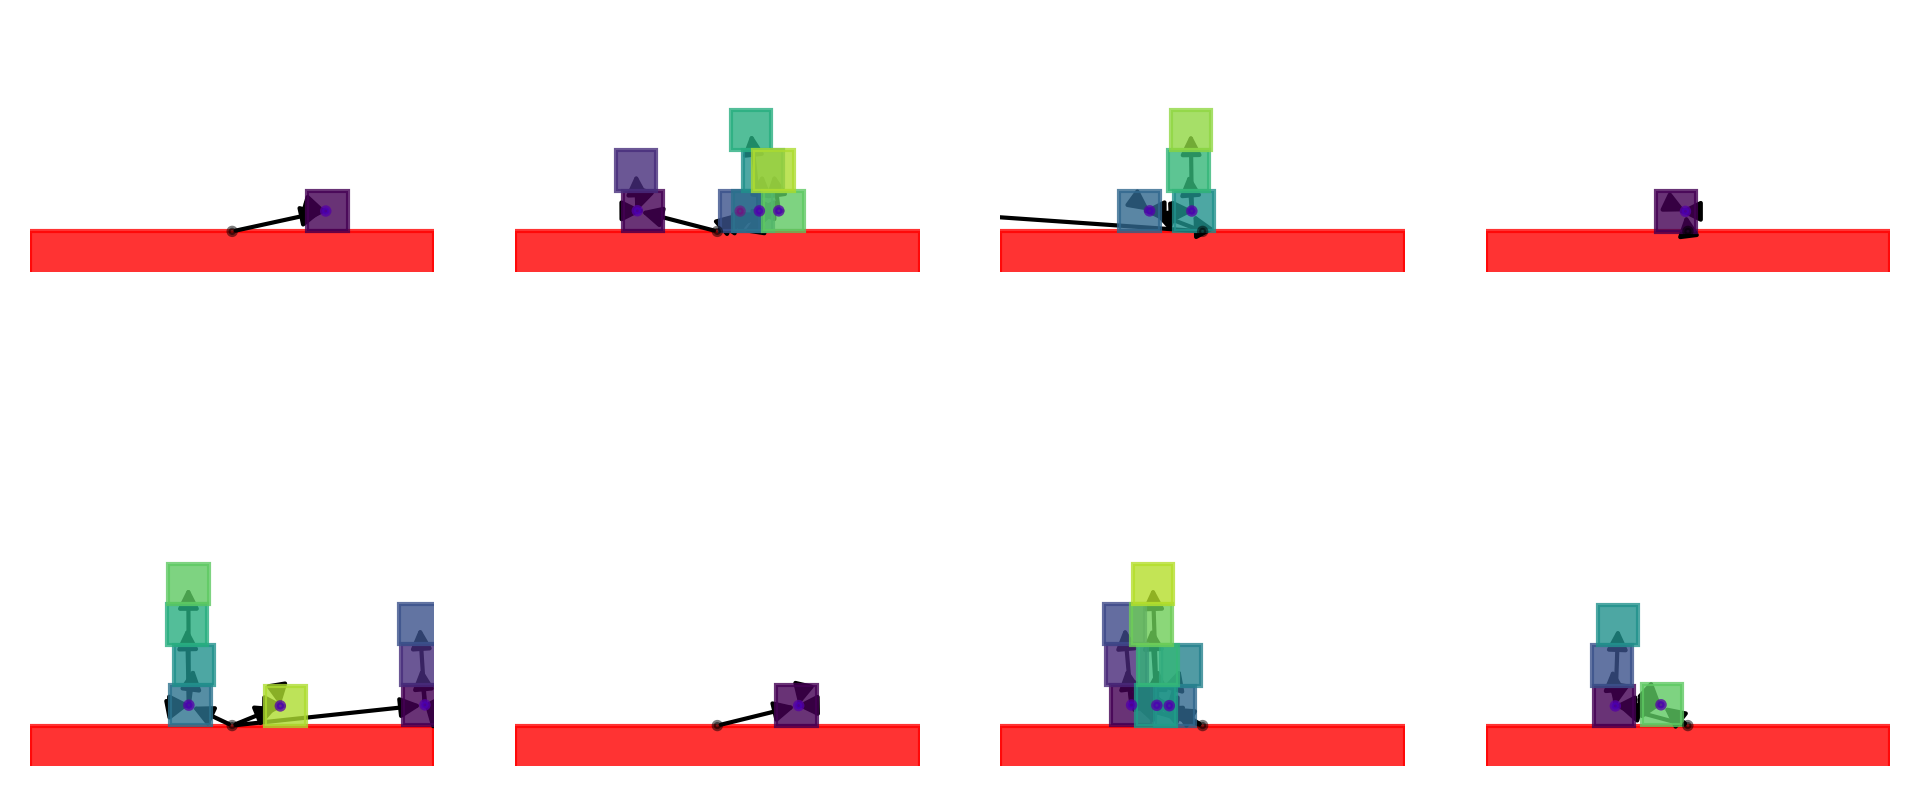

In [3]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

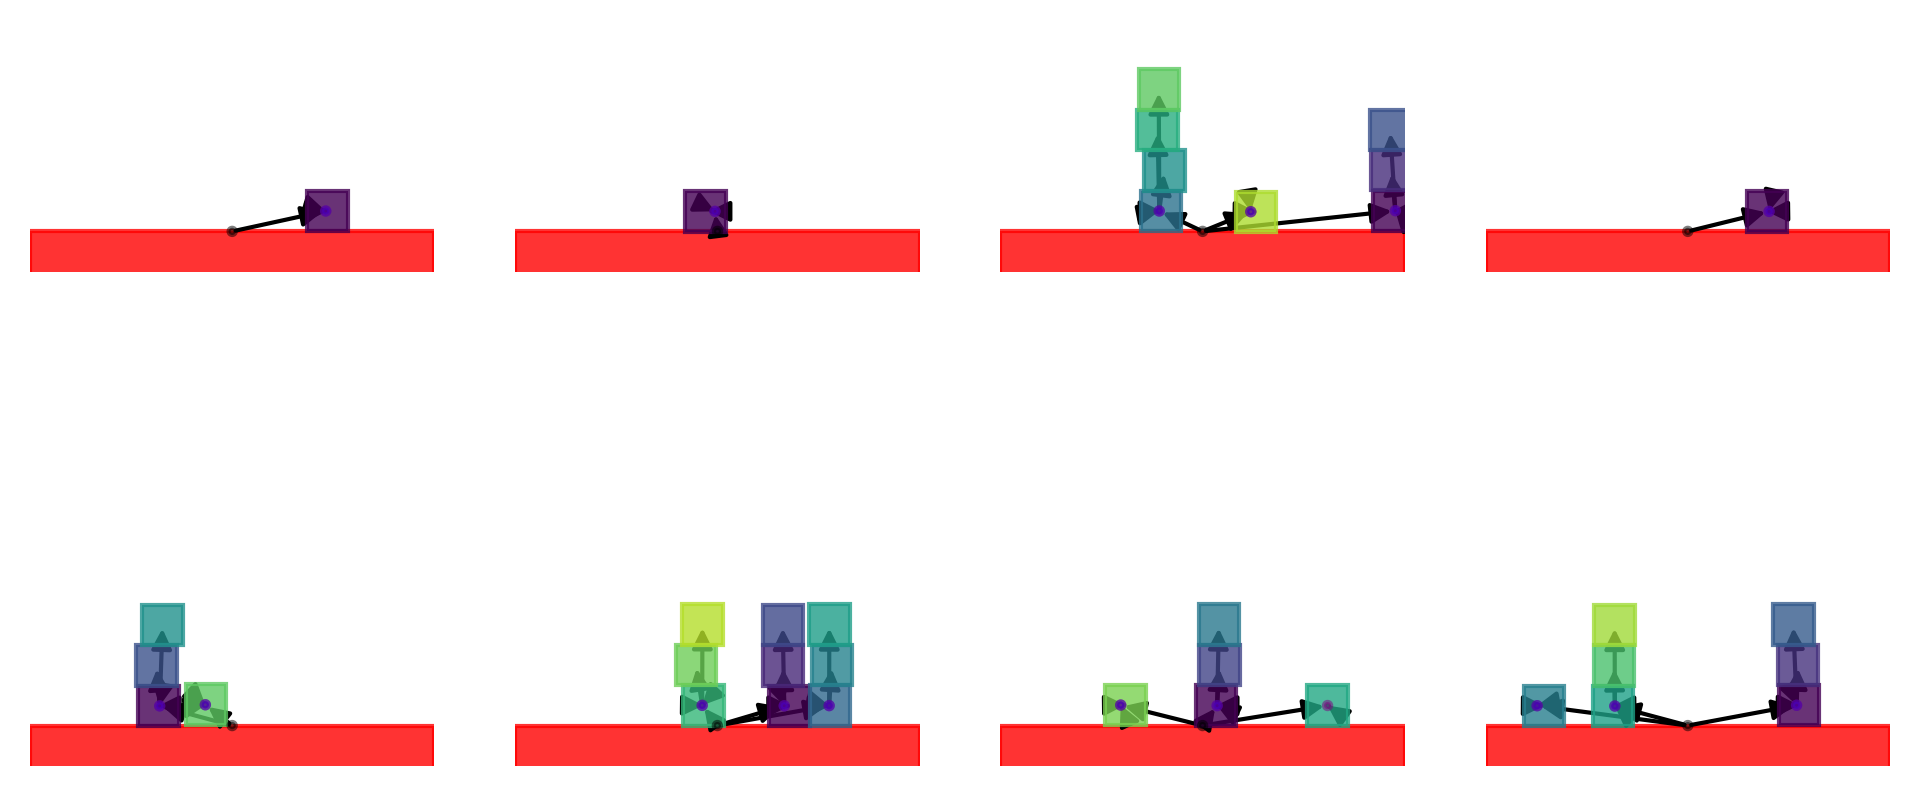

In [4]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [5]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

odict_keys(['_INPUT', 'Ground_26_sample_derived/xy', 'Ground_26_choose_children/sample_children_inclusion', 'Group_66_sample_derived/xy', 'Group_66_choose_children/sample_children_inclusion', 'Stack_59_sample_derived/xy', 'Stack_59_choose_children/sample_children_inclusion', 'Box_130_sample_derived/xy', 'Box_131_sample_derived/xy', '_RETURN'])


The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(339.81345000000005, 977.61655, -37.33605, 600.34605)

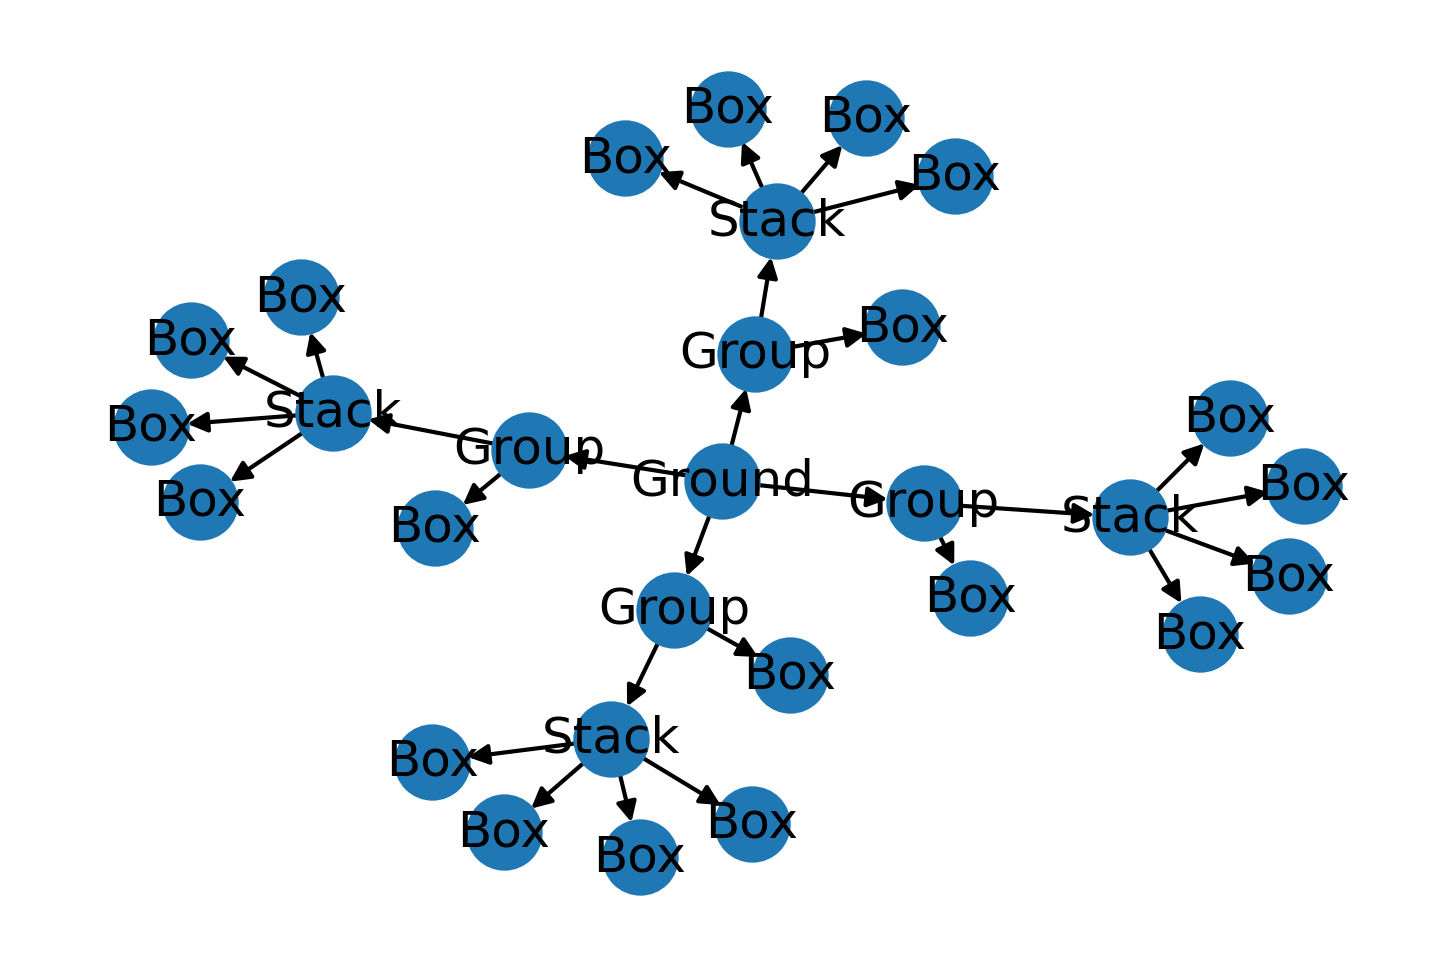

In [6]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

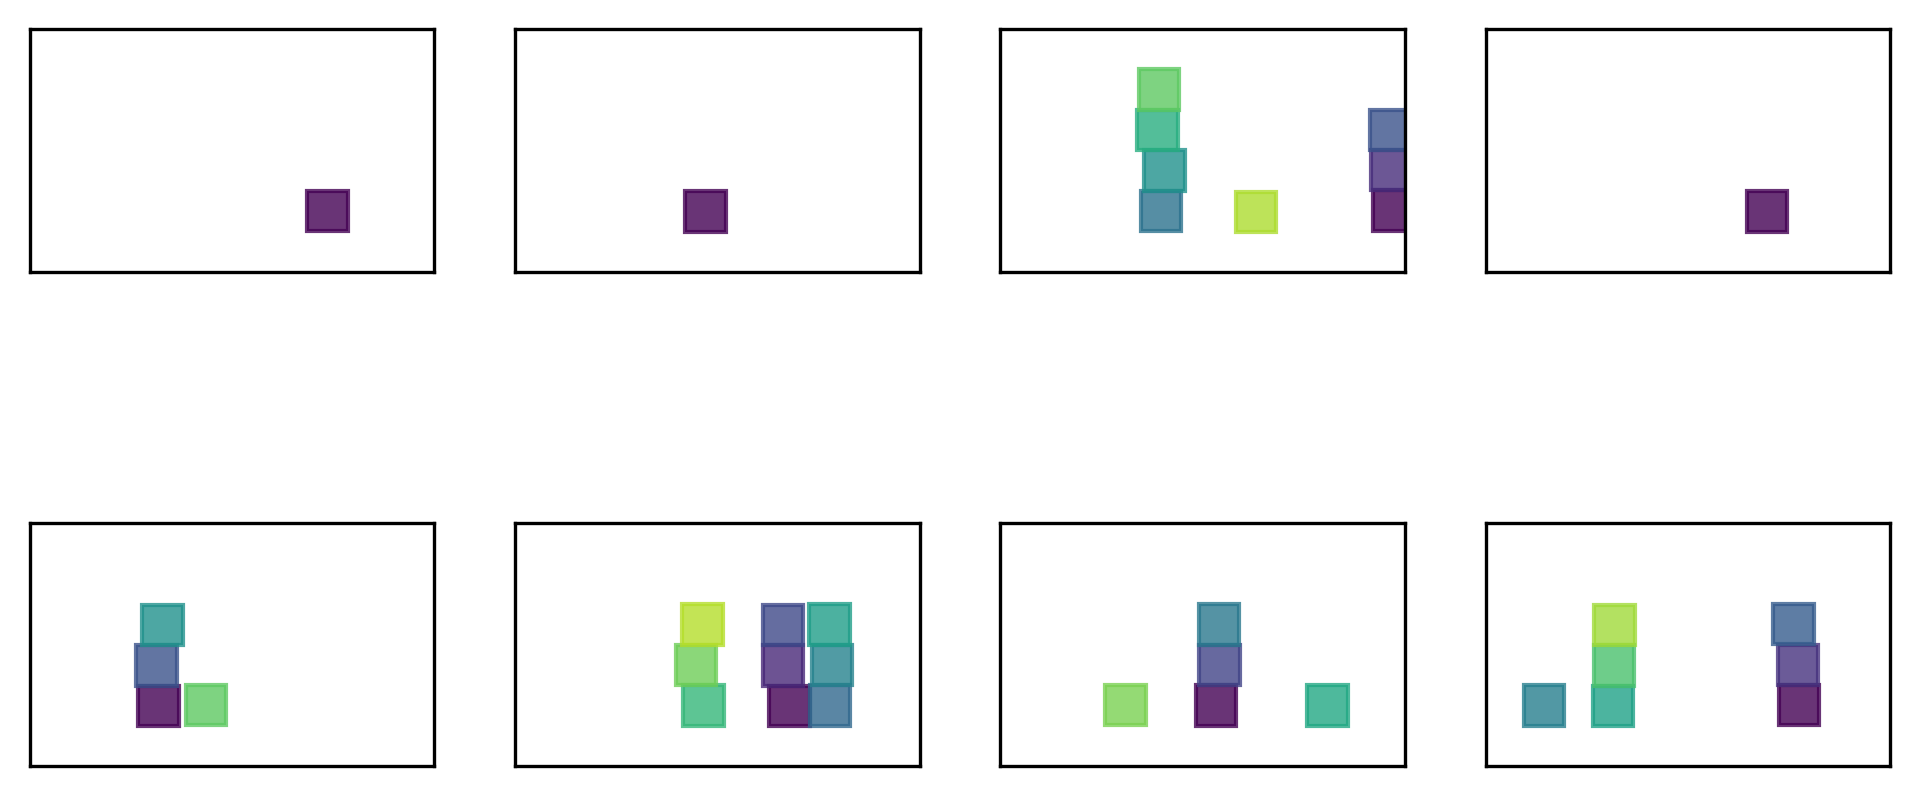

In [21]:
# Build observed trees
def make_observed_trees(full_trees):
    observed_trees = []
    for tree in full_trees:
        observed_tree = SceneTree()
        for node in tree:
            if isinstance(node, Box):
                observed_tree.add_node(node)
        observed_trees.append(observed_tree)
    return observed_trees
observed_trees = make_observed_trees(observed_full_trees)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [8]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

tensor([0.], grad_fn=<DivBackward0>)


In [9]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_training_example():
    success = False
    while not success:
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
    return scene_trees[0], [n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)]

def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        new_tree, new_observed_nodes = make_training_example()
        full_trees.append(new_tree)
        observed_nodes.append(new_observed_nodes)
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(100)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [23]:
observed_trees_for_training = make_observed_trees(full_trees_for_training)
observed_nodes_for_testing = make_observed_trees(full_trees_for_testing)

In [10]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GCN", gru_num_layers=5)
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 0:
    # Load encoder from saved run.
    #weight_path = "saved_models/20210602/encoder_supervised_-202.3508.torch"
    weight_path = "saved_models/20210610/encoder_supervised_gru_17.6656.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

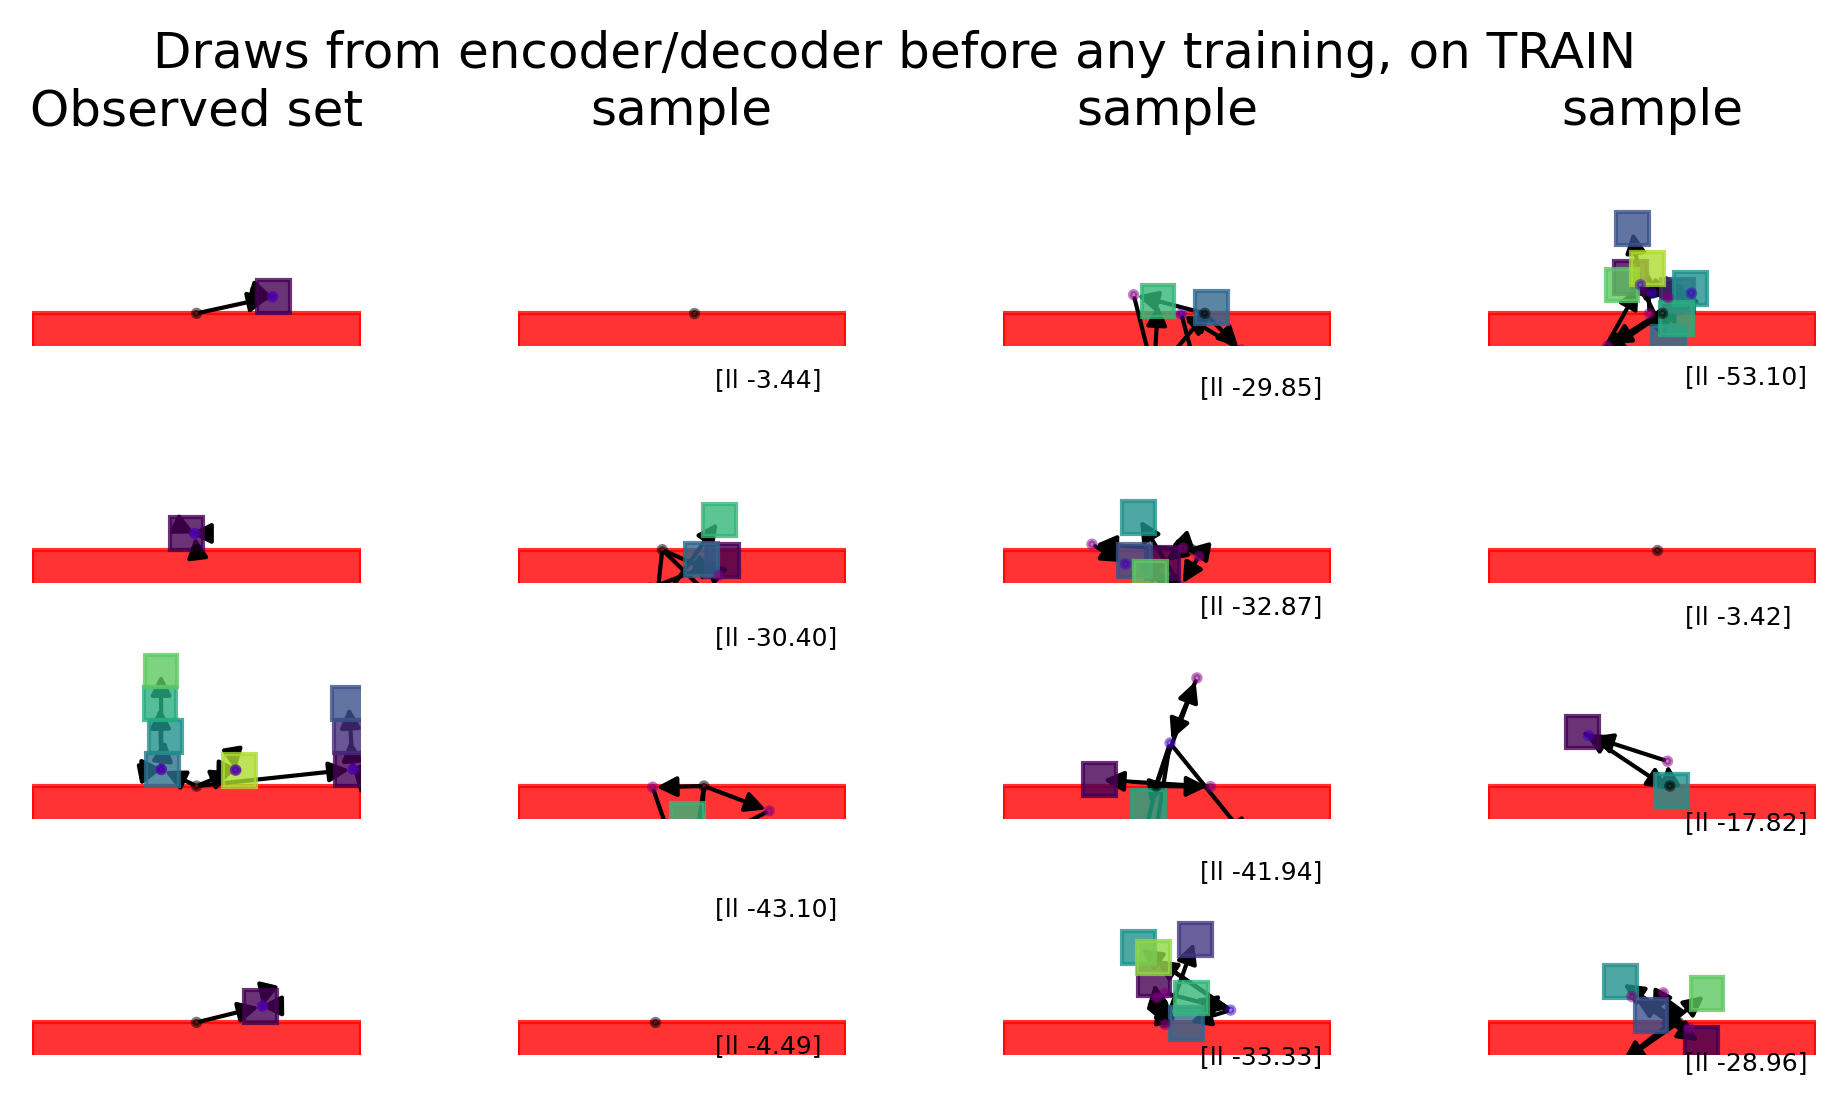

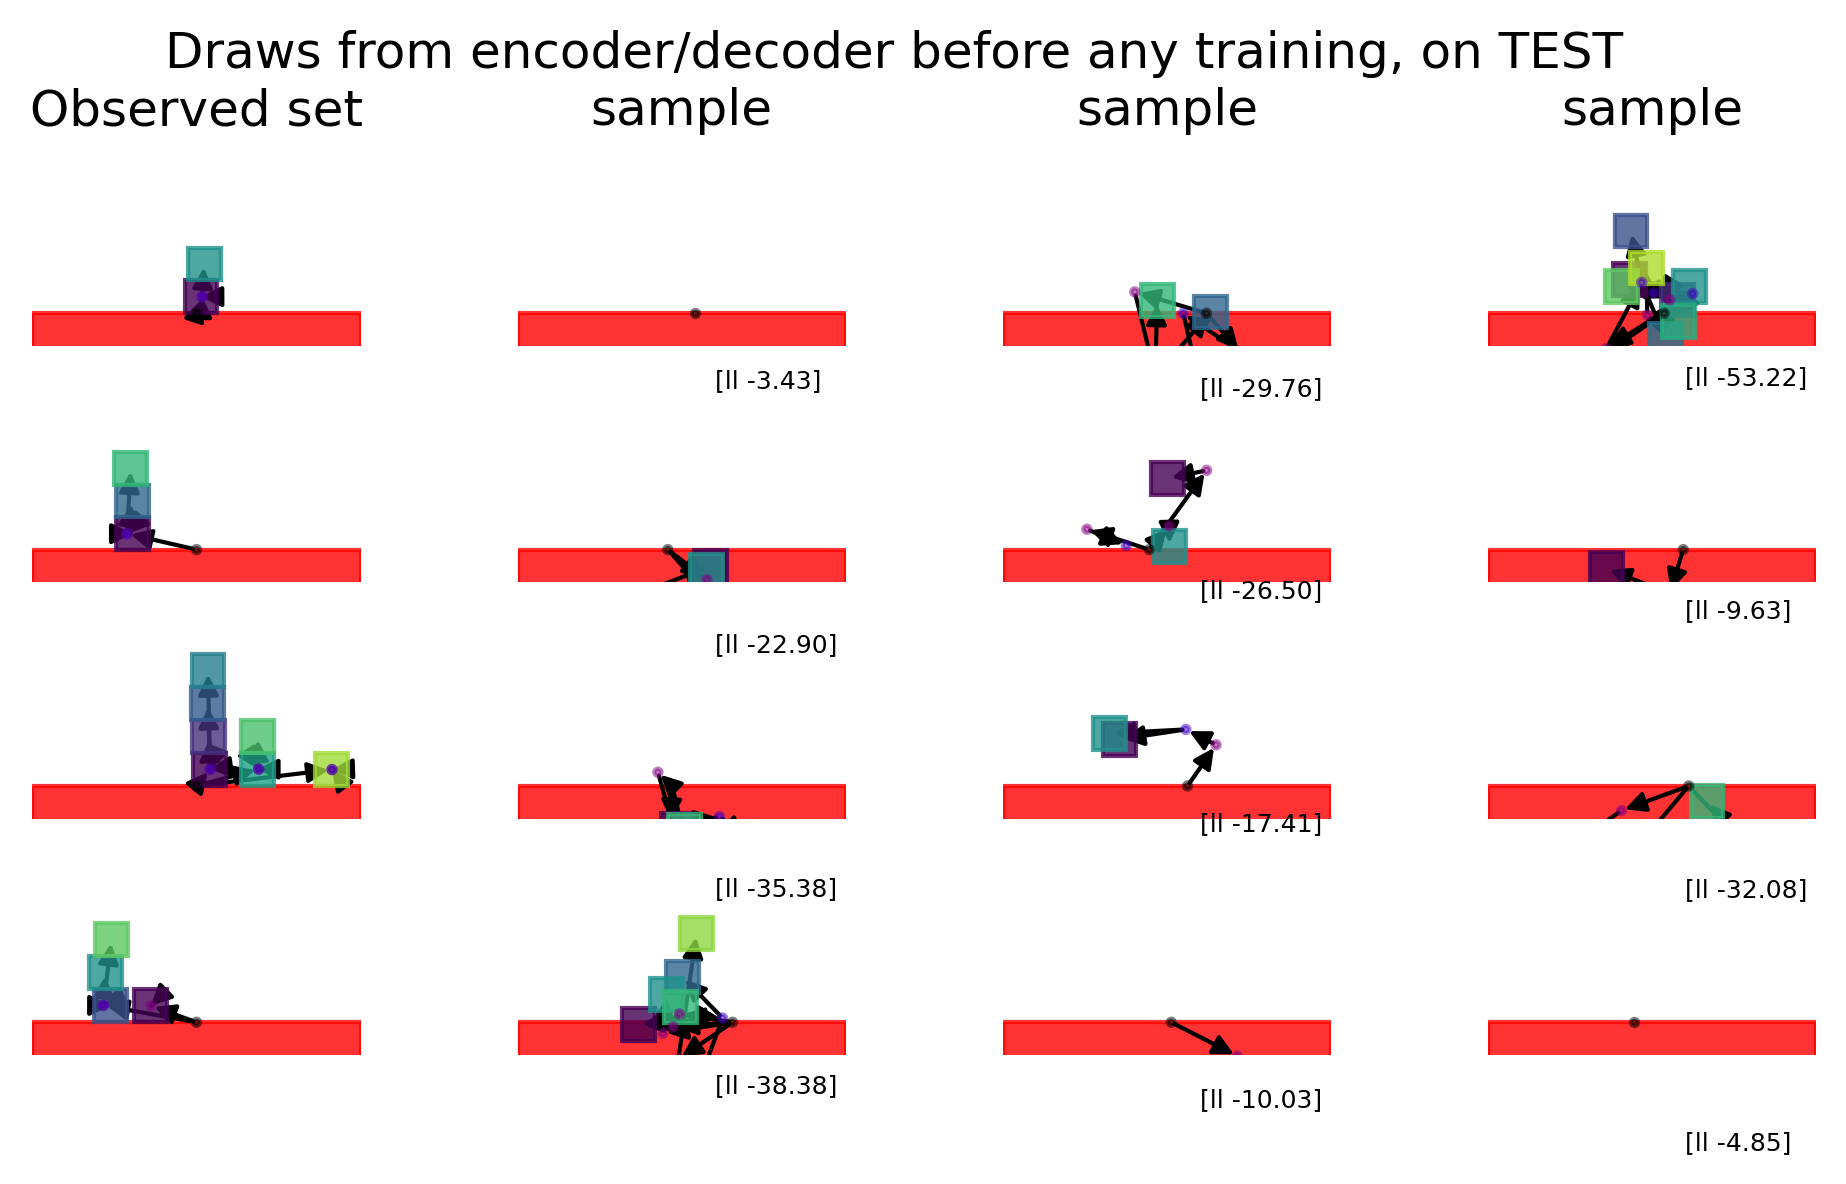

In [11]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

0: 36.762127
100: -56.544895
200: -65.467163
300: -79.022873
400: -84.719276


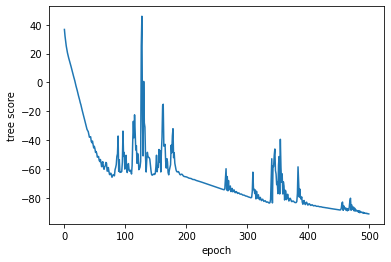

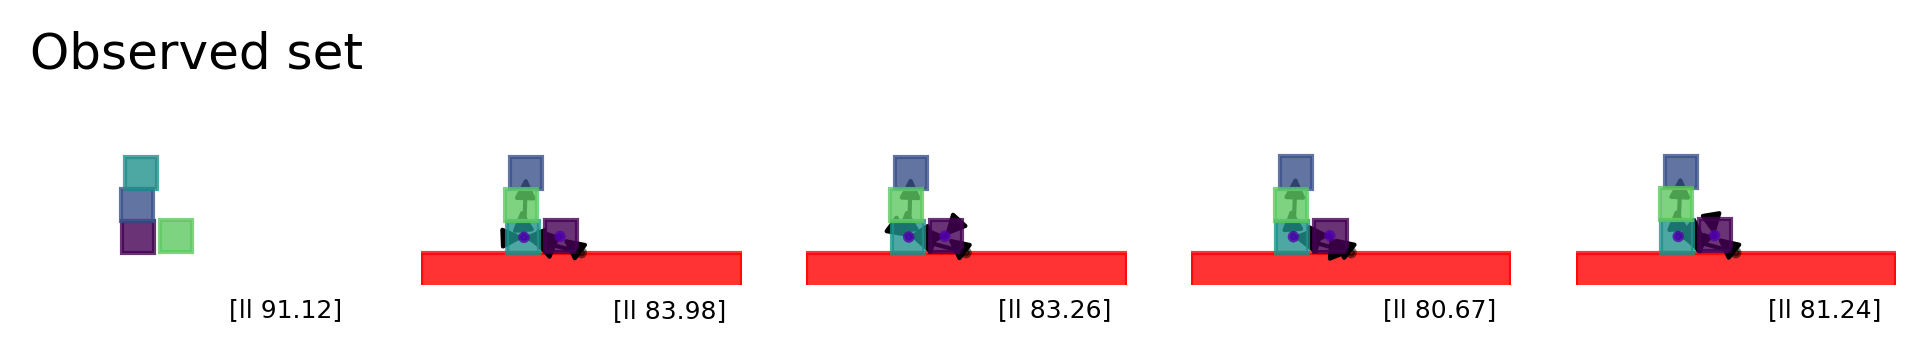

In [28]:
# Sanity-check grad descent: given a ground truth tree, can we
# recover the params of the auxiliary model that recover it?
full_tree = full_trees_for_training[4]
Nx = encoder.n_parameters
x = torch.normal(mean=torch.zeros(Nx), std=torch.ones(Nx)*0.1)
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=50, factor=0.5)
scores = []
for epoch in range(500):
    optimizer.zero_grad()
    score = -encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
    scores.append(score.detach().item())
    if epoch % 100 == 0:
        print("%d: %f" % (epoch, score))
    score.backward()
    optimizer.step()
    scheduler.step(score)
plt.plot(scores)
plt.xlabel("epoch")
plt.ylabel("tree score")
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 5
plt.subplot(1, N_width, 1)
draw_boxes(observed_trees_for_training[4], fig=plt.gcf(), ax=plt.gca(), block=False)
plt.text(x=1., y=-2., s="[ll %0.2f]" % -score, fontsize=6)
plt.title("Observed set")
for k in range(N_width - 1):
    ax = plt.subplot(1, N_width, k + 2)
    plt.title("Sample %d" % k)
    sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
    draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
    plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

0:Mean objective 7.36, lr 0.001000
10:Mean objective 3.19, lr 0.001000
20:Mean objective 0.19, lr 0.001000
30:Mean objective 0.12, lr 0.001000
40:Mean objective 0.03, lr 0.001000
50:Mean objective 0.18, lr 0.001000
60:Mean objective 0.11, lr 0.000500
70:Mean objective 0.14, lr 0.000500
80:Mean objective 0.02, lr 0.000500
90:Mean objective 0.01, lr 0.000500
100:Mean objective 0.01, lr 0.000500
110:Mean objective 0.00, lr 0.000250
120:Mean objective 0.04, lr 0.000250
130:Mean objective 0.01, lr 0.000250
140:Mean objective 0.00, lr 0.000250
150:Mean objective 0.00, lr 0.000250
160:Mean objective 0.00, lr 0.000125
170:Mean objective 0.00, lr 0.000125
180:Mean objective 0.00, lr 0.000125
190:Mean objective 0.00, lr 0.000125
200:Mean objective 0.00, lr 0.000125
210:Mean objective 0.00, lr 0.000063
220:Mean objective 0.00, lr 0.000063
230:Mean objective 0.00, lr 0.000063
240:Mean objective 0.00, lr 0.000063
250:Mean objective 0.00, lr 0.000063
260:Mean objective 0.00, lr 0.000031
270:Mean obj

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


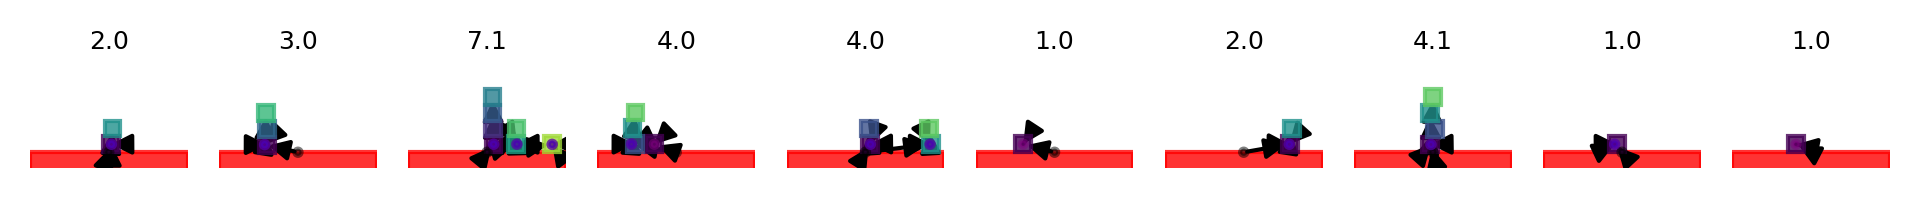

In [13]:
# Sanity check a simpler auxiliary task: can the encoder spit out x s.t. the first element of x
# is the number of objects?
# Training
N_EPOCHS = 500
N_ITERS_PER_EPOCH = 10
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=50, factor=0.5)

total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        total_objective += torch.mean(torch.square(x[0] - len(observed_nodes)))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    if (epoch % 10 == 0):
        print("%d:Mean objective %.2f, lr %f"
              % (epoch, mean_objective, optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 10
plt.subplot(1, N_width, 1)
for k in range(N_width):
    ax = plt.subplot(1, N_width, k + 1)
    plt.title("Sample %d" % k)
    observed_nodes = observed_nodes_for_testing[k]
    x = encoder(observed_nodes)
    draw_boxes(full_trees_for_testing[k], fig=fig, ax=ax, block=False)
    plt.title("%0.1f" % x[0].item(), fontsize=6)

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [ ]:
N_EPOCHS = 5000
N_ITERS_PER_EPOCH = 50
CHECKPOINT_SAVE_PERIOD=250
CLIP_VALUE = 1E3
torch.manual_seed(1234)

SETUP_TRAINING = True

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

if SETUP_TRAINING:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)

    continuous_score_history = []
    discrete_score_history = []
    total_objective_history = []
    lr_history = []
    score_history = []
    all_gradients_history = {name: [] for name, _ in encoder.named_parameters()}
    epoch = 0

while epoch < N_EPOCHS:
    total_discrete_score = 0.
    total_continuous_score = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        #observed_nodes = observed_nodes_for_training[iter_k]
        #full_tree = full_trees_for_training[iter_k]
        full_tree, observed_nodes = make_training_example()
        x = encoder(observed_nodes)
        
        discrete_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=True,
            include_continuous=False
        )
        total_discrete_score += discrete_score
        continuous_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=False,
            include_continuous=True
        )
        total_continuous_score += continuous_score
    
    mean_discrete_score = total_discrete_score / N_ITERS_PER_EPOCH
    mean_continuous_score = total_continuous_score / N_ITERS_PER_EPOCH
    
    discrete_score_history.append(mean_discrete_score.detach())
    continuous_score_history.append(mean_continuous_score.detach())

    # Weight continuous factor to bring it to the same order of
    # magnitude as the discrete score.
    #avg_d = torch.tensor(discrete_score_history[-AVERAGE_WINDOW]).mean()
    #avg_c = torch.tensor(continuous_score_history[-AVERAGE_WINDOW]).mean()
    
    mean_objective = mean_discrete_score * 10. + mean_continuous_score
    total_objective_history.append(mean_objective)
    score_history.append(mean_objective)
    lr_history.append(optimizer.param_groups[0]['lr'])
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f, discrete %.2f, continuous %.2f, lr %f"
              % (epoch, mean_objective, mean_discrete_score, mean_continuous_score,
                 optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        # log gradients
        for name, param in encoder.named_parameters():
            if param.grad is None:
                all_gradients_history[name].append(torch.zeros(param.shape))
            else:
                all_gradients_history[name].append(deepcopy(param.grad.data))

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
    if (epoch >= 0 and epoch % CHECKPOINT_SAVE_PERIOD == 0):
        save_encoder_state("saved_models/checkpoints/%d_%0.03f.torch" % (epoch, total_objective_history[-1]))

    epoch += 1

supervised_training_finish_time = time.time()

0:Mean objective -97.67, discrete -5.78, continuous -39.83, lr 0.001000
Saving to path  saved_models/checkpoints/0_-97.669.torch
Saved model to saved_models/checkpoints/0_-97.669.torch
1:Mean objective -81.43, discrete -5.03, continuous -31.16, lr 0.001000
2:Mean objective -65.25, discrete -4.23, continuous -22.91, lr 0.001000
3:Mean objective -70.37, discrete -4.51, continuous -25.26, lr 0.001000
4:Mean objective -70.84, discrete -4.60, continuous -24.89, lr 0.001000
5:Mean objective -64.55, discrete -4.25, continuous -22.06, lr 0.001000
6:Mean objective -64.58, discrete -4.39, continuous -20.68, lr 0.001000
7:Mean objective -58.46, discrete -3.86, continuous -19.81, lr 0.001000
8:Mean objective -70.90, discrete -4.71, continuous -23.80, lr 0.001000
9:Mean objective -58.29, discrete -3.80, continuous -20.25, lr 0.001000
10:Mean objective -70.08, discrete -4.52, continuous -24.85, lr 0.001000
11:Mean objective -60.94, discrete -4.02, continuous -20.76, lr 0.001000
12:Mean objective -58

111:Mean objective -54.98, discrete -3.70, continuous -17.97, lr 0.001000
112:Mean objective -55.55, discrete -3.55, continuous -20.02, lr 0.001000
113:Mean objective -50.62, discrete -3.39, continuous -16.73, lr 0.001000
114:Mean objective -55.31, discrete -3.75, continuous -17.79, lr 0.001000
115:Mean objective -50.29, discrete -3.31, continuous -17.20, lr 0.001000
116:Mean objective -43.01, discrete -2.92, continuous -13.82, lr 0.001000
117:Mean objective -53.92, discrete -3.58, continuous -18.10, lr 0.001000
118:Mean objective -50.67, discrete -3.45, continuous -16.19, lr 0.001000
119:Mean objective -49.56, discrete -3.20, continuous -17.56, lr 0.001000
120:Mean objective -63.27, discrete -4.10, continuous -22.26, lr 0.001000
121:Mean objective -50.51, discrete -3.27, continuous -17.77, lr 0.001000
122:Mean objective -49.78, discrete -3.30, continuous -16.79, lr 0.001000
123:Mean objective -57.47, discrete -3.67, continuous -20.77, lr 0.001000
124:Mean objective -57.00, discrete -3

222:Mean objective -52.97, discrete -3.46, continuous -18.41, lr 0.001000
223:Mean objective -47.81, discrete -3.21, continuous -15.70, lr 0.001000
224:Mean objective -47.97, discrete -3.24, continuous -15.59, lr 0.001000
225:Mean objective -49.99, discrete -3.41, continuous -15.92, lr 0.001000
226:Mean objective -51.00, discrete -3.46, continuous -16.41, lr 0.001000
227:Mean objective -46.54, discrete -3.04, continuous -16.12, lr 0.001000
228:Mean objective -102.20, discrete -4.08, continuous -61.38, lr 0.001000
229:Mean objective -45.75, discrete -3.12, continuous -14.52, lr 0.001000
230:Mean objective -63.69, discrete -3.50, continuous -28.71, lr 0.001000
231:Mean objective -56.80, discrete -3.71, continuous -19.71, lr 0.001000
232:Mean objective -60.56, discrete -3.86, continuous -21.95, lr 0.001000
233:Mean objective -58.08, discrete -3.87, continuous -19.40, lr 0.001000
234:Mean objective -53.32, discrete -3.51, continuous -18.26, lr 0.001000
235:Mean objective -53.50, discrete -

332:Mean objective -46.33, discrete -3.02, continuous -16.17, lr 0.001000
333:Mean objective -55.30, discrete -3.64, continuous -18.85, lr 0.001000
334:Mean objective -42.62, discrete -2.87, continuous -13.92, lr 0.001000
335:Mean objective -54.66, discrete -3.70, continuous -17.62, lr 0.001000
336:Mean objective -52.73, discrete -3.53, continuous -17.46, lr 0.001000
337:Mean objective -49.49, discrete -3.28, continuous -16.68, lr 0.001000
338:Mean objective -44.12, discrete -2.93, continuous -14.80, lr 0.001000
339:Mean objective -44.37, discrete -2.91, continuous -15.23, lr 0.001000
340:Mean objective -56.98, discrete -3.78, continuous -19.20, lr 0.001000
341:Mean objective -57.28, discrete -3.75, continuous -19.77, lr 0.001000
342:Mean objective -50.92, discrete -3.20, continuous -18.91, lr 0.001000
343:Mean objective -57.03, discrete -3.69, continuous -20.11, lr 0.001000
344:Mean objective -53.16, discrete -3.47, continuous -18.50, lr 0.001000
345:Mean objective -48.68, discrete -3

443:Mean objective -41.43, discrete -2.71, continuous -14.38, lr 0.001000
444:Mean objective -36.44, discrete -2.50, continuous -11.47, lr 0.001000
445:Mean objective -42.66, discrete -2.82, continuous -14.48, lr 0.001000
446:Mean objective -51.14, discrete -3.40, continuous -17.19, lr 0.001000
447:Mean objective -44.46, discrete -2.92, continuous -15.22, lr 0.001000
448:Mean objective -35.70, discrete -2.36, continuous -12.12, lr 0.001000
449:Mean objective -43.03, discrete -2.77, continuous -15.38, lr 0.001000
450:Mean objective -49.61, discrete -3.27, continuous -16.90, lr 0.001000
451:Mean objective -38.63, discrete -2.47, continuous -13.92, lr 0.001000
452:Mean objective -49.60, discrete -3.30, continuous -16.56, lr 0.001000
453:Mean objective -47.12, discrete -3.13, continuous -15.80, lr 0.001000
454:Mean objective -42.25, discrete -2.86, continuous -13.61, lr 0.001000
455:Mean objective -45.64, discrete -3.12, continuous -14.44, lr 0.001000
456:Mean objective -43.26, discrete -2

553:Mean objective -41.24, discrete -2.66, continuous -14.62, lr 0.001000
554:Mean objective -46.70, discrete -3.08, continuous -15.93, lr 0.001000
555:Mean objective -43.78, discrete -2.95, continuous -14.25, lr 0.001000
556:Mean objective -42.43, discrete -2.79, continuous -14.53, lr 0.001000
557:Mean objective -41.28, discrete -2.67, continuous -14.54, lr 0.001000
558:Mean objective -35.42, discrete -2.25, continuous -12.89, lr 0.001000
559:Mean objective -41.23, discrete -2.69, continuous -14.35, lr 0.001000
560:Mean objective -43.25, discrete -2.59, continuous -17.31, lr 0.001000
561:Mean objective -43.64, discrete -2.94, continuous -14.25, lr 0.001000
562:Mean objective -45.25, discrete -2.93, continuous -15.91, lr 0.001000
563:Mean objective -40.11, discrete -2.71, continuous -12.96, lr 0.001000
564:Mean objective -47.77, discrete -3.25, continuous -15.25, lr 0.001000
565:Mean objective -43.73, discrete -2.89, continuous -14.86, lr 0.001000
566:Mean objective -45.42, discrete -2

664:Mean objective -47.85, discrete -3.16, continuous -16.22, lr 0.001000
665:Mean objective -57.24, discrete -3.57, continuous -21.52, lr 0.001000
666:Mean objective -44.86, discrete -2.94, continuous -15.43, lr 0.001000
667:Mean objective -41.11, discrete -2.77, continuous -13.40, lr 0.001000
668:Mean objective -51.33, discrete -3.30, continuous -18.34, lr 0.001000
669:Mean objective -46.17, discrete -3.14, continuous -14.76, lr 0.001000
670:Mean objective -41.70, discrete -2.83, continuous -13.42, lr 0.001000
671:Mean objective -48.07, discrete -3.21, continuous -15.97, lr 0.001000
672:Mean objective -46.18, discrete -3.06, continuous -15.58, lr 0.001000
673:Mean objective -44.67, discrete -2.90, continuous -15.67, lr 0.001000
674:Mean objective -47.43, discrete -3.17, continuous -15.68, lr 0.001000
675:Mean objective -39.43, discrete -2.75, continuous -11.90, lr 0.001000
676:Mean objective -46.48, discrete -3.19, continuous -14.62, lr 0.001000
677:Mean objective -37.38, discrete -2

774:Mean objective -34.54, discrete -2.43, continuous -10.29, lr 0.000500
775:Mean objective -31.31, discrete -2.20, continuous -9.36, lr 0.000500
776:Mean objective -35.33, discrete -2.38, continuous -11.51, lr 0.000500
777:Mean objective -33.26, discrete -2.18, continuous -11.50, lr 0.000500
778:Mean objective -42.89, discrete -2.88, continuous -14.11, lr 0.000500
779:Mean objective -31.37, discrete -2.24, continuous -9.00, lr 0.000500
780:Mean objective -38.60, discrete -2.71, continuous -11.54, lr 0.000500
781:Mean objective -37.85, discrete -2.71, continuous -10.74, lr 0.000500
782:Mean objective -43.96, discrete -3.12, continuous -12.72, lr 0.000500
783:Mean objective -34.85, discrete -2.42, continuous -10.69, lr 0.000500
784:Mean objective -39.83, discrete -2.78, continuous -12.07, lr 0.000500
785:Mean objective -40.65, discrete -2.99, continuous -10.71, lr 0.000500
786:Mean objective -30.04, discrete -2.11, continuous -8.95, lr 0.000500
787:Mean objective -36.07, discrete -2.58

886:Mean objective -40.48, discrete -2.73, continuous -13.16, lr 0.000500
887:Mean objective -34.98, discrete -2.29, continuous -12.12, lr 0.000500
888:Mean objective -35.12, discrete -2.33, continuous -11.86, lr 0.000500
889:Mean objective -38.68, discrete -2.54, continuous -13.28, lr 0.000500
890:Mean objective -31.11, discrete -2.11, continuous -10.06, lr 0.000500
891:Mean objective -35.75, discrete -2.52, continuous -10.51, lr 0.000500
892:Mean objective -33.54, discrete -2.35, continuous -10.04, lr 0.000500
893:Mean objective -43.61, discrete -2.87, continuous -14.90, lr 0.000500
894:Mean objective -30.76, discrete -2.12, continuous -9.52, lr 0.000500
895:Mean objective -34.81, discrete -2.25, continuous -12.28, lr 0.000500
896:Mean objective -36.14, discrete -2.48, continuous -11.32, lr 0.000500
897:Mean objective -33.72, discrete -2.33, continuous -10.38, lr 0.000500
898:Mean objective -32.29, discrete -2.14, continuous -10.90, lr 0.000500
899:Mean objective -42.26, discrete -2.

998:Mean objective -35.07, discrete -2.53, continuous -9.78, lr 0.000500
999:Mean objective -43.10, discrete -3.05, continuous -12.65, lr 0.000500
1000:Mean objective -35.43, discrete -2.51, continuous -10.33, lr 0.000500
Saving to path  saved_models/checkpoints/1000_-35.427.torch
Saved model to saved_models/checkpoints/1000_-35.427.torch
1001:Mean objective -41.40, discrete -2.92, continuous -12.24, lr 0.000500
1002:Mean objective -34.49, discrete -2.37, continuous -10.79, lr 0.000500
1003:Mean objective -40.46, discrete -2.77, continuous -12.77, lr 0.000500
1004:Mean objective -31.53, discrete -2.24, continuous -9.12, lr 0.000500
1005:Mean objective -38.47, discrete -2.60, continuous -12.48, lr 0.000500
1006:Mean objective -40.55, discrete -2.80, continuous -12.51, lr 0.000500
1007:Mean objective -41.60, discrete -2.88, continuous -12.75, lr 0.000500
1008:Mean objective -35.62, discrete -2.45, continuous -11.08, lr 0.000500
1009:Mean objective -32.45, discrete -2.32, continuous -9.29

1107:Mean objective -38.40, discrete -2.74, continuous -10.96, lr 0.000500
1108:Mean objective -36.21, discrete -2.60, continuous -10.19, lr 0.000500
1109:Mean objective -42.01, discrete -2.89, continuous -13.15, lr 0.000500
1110:Mean objective -38.99, discrete -2.85, continuous -10.50, lr 0.000500
1111:Mean objective -29.43, discrete -2.19, continuous -7.58, lr 0.000500
1112:Mean objective -32.79, discrete -2.29, continuous -9.92, lr 0.000500
1113:Mean objective -33.17, discrete -2.41, continuous -9.08, lr 0.000500
1114:Mean objective -36.33, discrete -2.52, continuous -11.09, lr 0.000500
1115:Mean objective -31.60, discrete -2.29, continuous -8.70, lr 0.000500
1116:Mean objective -33.43, discrete -2.67, continuous -6.74, lr 0.000500
1117:Mean objective -32.52, discrete -2.38, continuous -8.68, lr 0.000500
1118:Mean objective -36.64, discrete -2.77, continuous -8.98, lr 0.000500
1119:Mean objective -39.06, discrete -3.05, continuous -8.60, lr 0.000500
1120:Mean objective -34.63, discr

1218:Mean objective -27.90, discrete -2.14, continuous -6.52, lr 0.000500
1219:Mean objective -30.81, discrete -2.32, continuous -7.61, lr 0.000500
1220:Mean objective -36.16, discrete -2.65, continuous -9.66, lr 0.000500
1221:Mean objective -23.46, discrete -1.81, continuous -5.37, lr 0.000500
1222:Mean objective -37.50, discrete -2.72, continuous -10.26, lr 0.000500
1223:Mean objective -28.92, discrete -2.20, continuous -6.92, lr 0.000500
1224:Mean objective -33.33, discrete -2.33, continuous -10.02, lr 0.000500
1225:Mean objective -27.98, discrete -2.07, continuous -7.30, lr 0.000500
1226:Mean objective -27.67, discrete -2.04, continuous -7.30, lr 0.000500
1227:Mean objective -35.50, discrete -2.65, continuous -8.96, lr 0.000500
1228:Mean objective -32.15, discrete -2.33, continuous -8.88, lr 0.000500
1229:Mean objective -33.58, discrete -2.42, continuous -9.36, lr 0.000250
1230:Mean objective -37.48, discrete -2.70, continuous -10.47, lr 0.000250
1231:Mean objective -28.80, discret

1327:Mean objective -36.95, discrete -2.58, continuous -11.15, lr 0.000250
1328:Mean objective -28.00, discrete -2.15, continuous -6.48, lr 0.000250
1329:Mean objective -24.22, discrete -1.92, continuous -5.03, lr 0.000250
1330:Mean objective -23.22, discrete -1.85, continuous -4.72, lr 0.000250
1331:Mean objective -30.04, discrete -2.39, continuous -6.13, lr 0.000250
1332:Mean objective -24.25, discrete -2.05, continuous -3.71, lr 0.000250
1333:Mean objective -24.01, discrete -2.02, continuous -3.81, lr 0.000250
1334:Mean objective -27.05, discrete -1.96, continuous -7.41, lr 0.000250
1335:Mean objective -27.05, discrete -2.06, continuous -6.45, lr 0.000250
1336:Mean objective -27.13, discrete -2.15, continuous -5.67, lr 0.000250
1337:Mean objective -27.86, discrete -2.21, continuous -5.74, lr 0.000250
1338:Mean objective -28.88, discrete -2.27, continuous -6.16, lr 0.000250
1339:Mean objective -44.07, discrete -2.38, continuous -20.27, lr 0.000250
1340:Mean objective -36.13, discrete

1438:Mean objective -25.65, discrete -2.14, continuous -4.26, lr 0.000250
1439:Mean objective -29.40, discrete -2.18, continuous -7.61, lr 0.000250
1440:Mean objective -29.63, discrete -2.46, continuous -4.99, lr 0.000250
1441:Mean objective -21.13, discrete -1.68, continuous -4.34, lr 0.000250
1442:Mean objective -23.98, discrete -1.96, continuous -4.37, lr 0.000250
1443:Mean objective -20.66, discrete -1.85, continuous -2.19, lr 0.000250
1444:Mean objective -22.95, discrete -1.80, continuous -4.93, lr 0.000250
1445:Mean objective -31.08, discrete -2.43, continuous -6.77, lr 0.000250
1446:Mean objective -19.84, discrete -1.75, continuous -2.36, lr 0.000250
1447:Mean objective -29.81, discrete -2.21, continuous -7.68, lr 0.000250
1448:Mean objective -32.52, discrete -2.55, continuous -7.00, lr 0.000250
1449:Mean objective -33.37, discrete -2.58, continuous -7.57, lr 0.000250
1450:Mean objective -25.39, discrete -1.92, continuous -6.20, lr 0.000250
1451:Mean objective -25.30, discrete -

1548:Mean objective -38.28, discrete -2.66, continuous -11.72, lr 0.000250
1549:Mean objective -25.50, discrete -1.98, continuous -5.65, lr 0.000250
1550:Mean objective -28.42, discrete -2.11, continuous -7.27, lr 0.000250
1551:Mean objective -28.60, discrete -2.05, continuous -8.05, lr 0.000250
1552:Mean objective -29.80, discrete -2.22, continuous -7.64, lr 0.000250
1553:Mean objective -28.34, discrete -2.05, continuous -7.84, lr 0.000250
1554:Mean objective -30.92, discrete -2.32, continuous -7.74, lr 0.000250
1555:Mean objective -25.61, discrete -1.92, continuous -6.40, lr 0.000250
1556:Mean objective -24.84, discrete -1.85, continuous -6.35, lr 0.000250
1557:Mean objective -24.31, discrete -1.89, continuous -5.46, lr 0.000250
1558:Mean objective -24.51, discrete -1.85, continuous -6.06, lr 0.000250
1559:Mean objective -30.89, discrete -2.33, continuous -7.55, lr 0.000250
1560:Mean objective -33.77, discrete -2.65, continuous -7.27, lr 0.000250
1561:Mean objective -27.99, discrete 

1659:Mean objective -24.25, discrete -2.01, continuous -4.12, lr 0.000250
1660:Mean objective -24.36, discrete -2.00, continuous -4.35, lr 0.000250
1661:Mean objective -27.71, discrete -2.29, continuous -4.78, lr 0.000250
1662:Mean objective -25.93, discrete -2.08, continuous -5.12, lr 0.000250
1663:Mean objective -31.26, discrete -2.46, continuous -6.68, lr 0.000250
1664:Mean objective -30.77, discrete -2.30, continuous -7.82, lr 0.000250
1665:Mean objective -21.40, discrete -1.59, continuous -5.50, lr 0.000250
1666:Mean objective -21.50, discrete -1.85, continuous -2.99, lr 0.000250
1667:Mean objective -25.47, discrete -1.94, continuous -6.10, lr 0.000250
1668:Mean objective -24.68, discrete -1.90, continuous -5.73, lr 0.000250
1669:Mean objective -32.93, discrete -2.45, continuous -8.39, lr 0.000250
1670:Mean objective -19.97, discrete -1.61, continuous -3.86, lr 0.000250
1671:Mean objective -12.68, discrete -1.27, continuous 0.05, lr 0.000250
1672:Mean objective -21.97, discrete -1

1769:Mean objective -20.85, discrete -1.83, continuous -2.60, lr 0.000250
1770:Mean objective -23.88, discrete -1.92, continuous -4.65, lr 0.000250
1771:Mean objective -32.88, discrete -2.19, continuous -10.99, lr 0.000250
1772:Mean objective -17.96, discrete -1.62, continuous -1.76, lr 0.000250
1773:Mean objective -27.22, discrete -2.23, continuous -4.91, lr 0.000250
1774:Mean objective -16.71, discrete -1.56, continuous -1.08, lr 0.000250
1775:Mean objective -27.12, discrete -2.28, continuous -4.37, lr 0.000250
1776:Mean objective -24.25, discrete -2.09, continuous -3.30, lr 0.000250
1777:Mean objective -29.32, discrete -2.39, continuous -5.41, lr 0.000250
1778:Mean objective -33.32, discrete -2.30, continuous -10.34, lr 0.000250
1779:Mean objective -29.88, discrete -1.96, continuous -10.28, lr 0.000250
1780:Mean objective -26.67, discrete -2.08, continuous -5.91, lr 0.000250
1781:Mean objective -25.03, discrete -1.99, continuous -5.15, lr 0.000250
1782:Mean objective -20.97, discret

1880:Mean objective -26.19, discrete -1.75, continuous -8.72, lr 0.000250
1881:Mean objective -24.81, discrete -2.18, continuous -3.02, lr 0.000250
1882:Mean objective -24.81, discrete -2.05, continuous -4.34, lr 0.000250
1883:Mean objective -23.64, discrete -1.94, continuous -4.25, lr 0.000250
1884:Mean objective -16.96, discrete -1.58, continuous -1.12, lr 0.000250
1885:Mean objective -16.80, discrete -1.68, continuous -0.03, lr 0.000250
1886:Mean objective -23.51, discrete -1.95, continuous -3.98, lr 0.000250
1887:Mean objective -32.44, discrete -2.22, continuous -10.20, lr 0.000250
1888:Mean objective -24.05, discrete -2.05, continuous -3.55, lr 0.000250
1889:Mean objective -19.56, discrete -1.76, continuous -1.92, lr 0.000250
1890:Mean objective -21.94, discrete -1.82, continuous -3.79, lr 0.000250
1891:Mean objective -33.44, discrete -2.33, continuous -10.14, lr 0.000250
1892:Mean objective -31.10, discrete -2.47, continuous -6.38, lr 0.000250
1893:Mean objective -22.64, discrete

1991:Mean objective -30.18, discrete -2.39, continuous -6.31, lr 0.000250
1992:Mean objective -18.60, discrete -1.52, continuous -3.41, lr 0.000250
1993:Mean objective -22.94, discrete -2.01, continuous -2.84, lr 0.000250
1994:Mean objective -25.25, discrete -2.27, continuous -2.51, lr 0.000250
1995:Mean objective -29.81, discrete -1.95, continuous -10.33, lr 0.000250
1996:Mean objective -22.82, discrete -1.94, continuous -3.42, lr 0.000250
1997:Mean objective -19.20, discrete -1.69, continuous -2.29, lr 0.000250
1998:Mean objective -30.22, discrete -1.98, continuous -10.44, lr 0.000250
1999:Mean objective -25.49, discrete -2.05, continuous -5.01, lr 0.000250
2000:Mean objective -34.57, discrete -2.67, continuous -7.85, lr 0.000250
Saving to path  saved_models/checkpoints/2000_-34.568.torch
Saved model to saved_models/checkpoints/2000_-34.568.torch
2001:Mean objective -29.25, discrete -2.31, continuous -6.18, lr 0.000250
2002:Mean objective -24.93, discrete -2.01, continuous -4.78, lr 

2101:Mean objective -26.13, discrete -2.00, continuous -6.15, lr 0.000250
2102:Mean objective -27.85, discrete -2.01, continuous -7.78, lr 0.000250
2103:Mean objective -28.72, discrete -2.41, continuous -4.62, lr 0.000250
2104:Mean objective -17.14, discrete -1.62, continuous -0.95, lr 0.000250
2105:Mean objective -23.92, discrete -2.15, continuous -2.41, lr 0.000250
2106:Mean objective -16.22, discrete -1.52, continuous -1.02, lr 0.000250
2107:Mean objective -25.66, discrete -1.93, continuous -6.40, lr 0.000250
2108:Mean objective -17.04, discrete -1.51, continuous -1.91, lr 0.000250
2109:Mean objective -21.68, discrete -1.74, continuous -4.29, lr 0.000250
2110:Mean objective -19.65, discrete -1.66, continuous -3.01, lr 0.000250
2111:Mean objective -21.03, discrete -1.99, continuous -1.08, lr 0.000250
2112:Mean objective -23.45, discrete -2.11, continuous -2.39, lr 0.000250
2113:Mean objective -23.42, discrete -1.97, continuous -3.74, lr 0.000250
2114:Mean objective -29.18, discrete -

2212:Mean objective -18.76, discrete -1.81, continuous -0.62, lr 0.000250
2213:Mean objective -24.81, discrete -1.99, continuous -4.91, lr 0.000250
2214:Mean objective -29.07, discrete -2.45, continuous -4.62, lr 0.000250
2215:Mean objective -22.69, discrete -1.95, continuous -3.19, lr 0.000250
2216:Mean objective -14.21, discrete -1.46, continuous 0.39, lr 0.000250
2217:Mean objective -11.62, discrete -1.16, continuous -0.05, lr 0.000250
2218:Mean objective -23.26, discrete -2.05, continuous -2.75, lr 0.000250
2219:Mean objective -21.96, discrete -1.96, continuous -2.39, lr 0.000250
2220:Mean objective -36.62, discrete -2.53, continuous -11.29, lr 0.000250
2221:Mean objective -19.81, discrete -1.49, continuous -4.91, lr 0.000250
2222:Mean objective -24.52, discrete -2.01, continuous -4.38, lr 0.000250
2223:Mean objective -35.20, discrete -2.26, continuous -12.55, lr 0.000250
2224:Mean objective -30.28, discrete -2.43, continuous -6.02, lr 0.000250
2225:Mean objective -28.33, discrete 

2322:Mean objective -23.34, discrete -1.83, continuous -5.02, lr 0.000125
2323:Mean objective -22.42, discrete -1.79, continuous -4.52, lr 0.000125
2324:Mean objective -17.68, discrete -1.61, continuous -1.60, lr 0.000125
2325:Mean objective -18.53, discrete -1.65, continuous -2.06, lr 0.000125
2326:Mean objective -21.16, discrete -1.82, continuous -2.94, lr 0.000125
2327:Mean objective -19.92, discrete -1.89, continuous -1.06, lr 0.000125
2328:Mean objective -16.99, discrete -1.69, continuous -0.06, lr 0.000125
2329:Mean objective -21.20, discrete -2.01, continuous -1.07, lr 0.000125
2330:Mean objective -24.57, discrete -2.15, continuous -3.12, lr 0.000125
2331:Mean objective -22.47, discrete -1.97, continuous -2.79, lr 0.000125
2332:Mean objective -19.51, discrete -1.89, continuous -0.57, lr 0.000125
2333:Mean objective -19.58, discrete -1.73, continuous -2.26, lr 0.000125
2334:Mean objective -15.91, discrete -1.69, continuous 1.01, lr 0.000125
2335:Mean objective -19.36, discrete -1

2434:Mean objective -19.81, discrete -1.82, continuous -1.65, lr 0.000125
2435:Mean objective -18.44, discrete -1.84, continuous -0.08, lr 0.000125
2436:Mean objective -16.59, discrete -1.69, continuous 0.34, lr 0.000125
2437:Mean objective -19.55, discrete -1.85, continuous -1.10, lr 0.000125
2438:Mean objective -27.51, discrete -2.37, continuous -3.78, lr 0.000125
2439:Mean objective -20.59, discrete -1.92, continuous -1.38, lr 0.000125
2440:Mean objective -27.52, discrete -2.37, continuous -3.82, lr 0.000125
2441:Mean objective -17.83, discrete -1.84, continuous 0.55, lr 0.000125
2442:Mean objective -19.42, discrete -1.91, continuous -0.32, lr 0.000125
2443:Mean objective -17.85, discrete -1.59, continuous -1.91, lr 0.000125
2444:Mean objective -22.54, discrete -2.06, continuous -1.91, lr 0.000125
2445:Mean objective -16.29, discrete -1.76, continuous 1.35, lr 0.000125
2446:Mean objective -25.21, discrete -1.90, continuous -6.21, lr 0.000125
2447:Mean objective -17.20, discrete -1.7

2544:Mean objective -17.04, discrete -1.86, continuous 1.59, lr 0.000125
2545:Mean objective -15.03, discrete -1.53, continuous 0.27, lr 0.000125
2546:Mean objective -16.68, discrete -1.83, continuous 1.58, lr 0.000125
2547:Mean objective -18.50, discrete -1.87, continuous 0.24, lr 0.000125
2548:Mean objective -22.07, discrete -2.22, continuous 0.12, lr 0.000125
2549:Mean objective -19.44, discrete -1.90, continuous -0.43, lr 0.000125
2550:Mean objective -15.38, discrete -1.77, continuous 2.28, lr 0.000125
2551:Mean objective -22.29, discrete -2.09, continuous -1.39, lr 0.000125
2552:Mean objective -17.85, discrete -1.90, continuous 1.17, lr 0.000125
2553:Mean objective -23.70, discrete -2.21, continuous -1.64, lr 0.000125
2554:Mean objective -21.44, discrete -1.99, continuous -1.51, lr 0.000125
2555:Mean objective -12.83, discrete -1.61, continuous 3.23, lr 0.000125
2556:Mean objective -31.51, discrete -2.57, continuous -5.79, lr 0.000125
2557:Mean objective -12.14, discrete -1.64, co

2656:Mean objective -26.23, discrete -2.38, continuous -2.45, lr 0.000063
2657:Mean objective -18.02, discrete -1.95, continuous 1.50, lr 0.000063
2658:Mean objective -16.40, discrete -1.66, continuous 0.21, lr 0.000063
2659:Mean objective -13.79, discrete -1.60, continuous 2.26, lr 0.000063
2660:Mean objective -31.32, discrete -2.43, continuous -7.03, lr 0.000063
2661:Mean objective -23.35, discrete -2.02, continuous -3.14, lr 0.000063
2662:Mean objective -20.41, discrete -1.88, continuous -1.59, lr 0.000063
2663:Mean objective -23.09, discrete -1.84, continuous -4.67, lr 0.000063
2664:Mean objective -20.43, discrete -1.91, continuous -1.31, lr 0.000063
2665:Mean objective -16.77, discrete -1.73, continuous 0.56, lr 0.000063
2666:Mean objective -15.18, discrete -1.69, continuous 1.77, lr 0.000063
2667:Mean objective -19.17, discrete -1.85, continuous -0.65, lr 0.000063
2668:Mean objective -16.48, discrete -1.52, continuous -1.25, lr 0.000063
2669:Mean objective -19.32, discrete -1.91,

2767:Mean objective -11.60, discrete -1.42, continuous 2.63, lr 0.000063
2768:Mean objective -20.75, discrete -1.76, continuous -3.16, lr 0.000063
2769:Mean objective -21.74, discrete -2.08, continuous -0.90, lr 0.000063
2770:Mean objective -21.52, discrete -2.06, continuous -0.97, lr 0.000063
2771:Mean objective -18.18, discrete -1.86, continuous 0.41, lr 0.000063
2772:Mean objective -21.06, discrete -2.06, continuous -0.43, lr 0.000063
2773:Mean objective -12.81, discrete -1.54, continuous 2.59, lr 0.000063
2774:Mean objective -20.67, discrete -1.99, continuous -0.76, lr 0.000063
2775:Mean objective -17.30, discrete -1.92, continuous 1.89, lr 0.000063
2776:Mean objective -17.41, discrete -1.78, continuous 0.39, lr 0.000063
2777:Mean objective -13.78, discrete -1.60, continuous 2.19, lr 0.000063
2778:Mean objective -5.50, discrete -1.31, continuous 7.64, lr 0.000063
2779:Mean objective -13.80, discrete -1.63, continuous 2.49, lr 0.000063
2780:Mean objective -17.49, discrete -1.82, con

2879:Mean objective -24.32, discrete -2.17, continuous -2.66, lr 0.000063
2880:Mean objective -21.45, discrete -2.12, continuous -0.30, lr 0.000063
2881:Mean objective -21.48, discrete -2.17, continuous 0.23, lr 0.000063
2882:Mean objective -20.65, discrete -2.17, continuous 1.08, lr 0.000063
2883:Mean objective -10.34, discrete -1.52, continuous 4.85, lr 0.000063
2884:Mean objective -8.18, discrete -1.35, continuous 5.28, lr 0.000063
2885:Mean objective -16.20, discrete -1.86, continuous 2.36, lr 0.000063
2886:Mean objective -15.92, discrete -1.92, continuous 3.32, lr 0.000063
2887:Mean objective -9.45, discrete -1.22, continuous 2.76, lr 0.000063
2888:Mean objective -20.61, discrete -2.18, continuous 1.17, lr 0.000063
2889:Mean objective -20.09, discrete -1.89, continuous -1.17, lr 0.000063
2890:Mean objective -36.89, discrete -2.09, continuous -16.03, lr 0.000063
2891:Mean objective -14.01, discrete -1.63, continuous 2.31, lr 0.000063
2892:Mean objective -13.63, discrete -1.56, cont

2992:Mean objective -19.33, discrete -2.03, continuous 0.94, lr 0.000063
2993:Mean objective -13.54, discrete -1.70, continuous 3.49, lr 0.000063
2994:Mean objective -20.24, discrete -2.26, continuous 2.31, lr 0.000063
2995:Mean objective -18.67, discrete -1.87, continuous 0.01, lr 0.000063
2996:Mean objective -16.15, discrete -1.79, continuous 1.79, lr 0.000063
2997:Mean objective -12.45, discrete -1.53, continuous 2.90, lr 0.000063
2998:Mean objective -23.78, discrete -2.20, continuous -1.79, lr 0.000063
2999:Mean objective -23.54, discrete -1.93, continuous -4.28, lr 0.000063
3000:Mean objective -12.54, discrete -1.52, continuous 2.70, lr 0.000063
Saving to path  saved_models/checkpoints/3000_-12.538.torch
Saved model to saved_models/checkpoints/3000_-12.538.torch
3001:Mean objective -12.69, discrete -1.66, continuous 3.91, lr 0.000063
3002:Mean objective -16.52, discrete -1.70, continuous 0.50, lr 0.000063
3003:Mean objective -18.52, discrete -2.07, continuous 2.16, lr 0.000063
300

3103:Mean objective -18.06, discrete -1.72, continuous -0.87, lr 0.000063
3104:Mean objective -12.05, discrete -1.74, continuous 5.30, lr 0.000063
3105:Mean objective -20.59, discrete -2.17, continuous 1.15, lr 0.000063
3106:Mean objective -15.87, discrete -1.69, continuous 0.98, lr 0.000063
3107:Mean objective -12.18, discrete -1.47, continuous 2.52, lr 0.000063
3108:Mean objective -6.97, discrete -1.18, continuous 4.80, lr 0.000063
3109:Mean objective -21.38, discrete -2.18, continuous 0.41, lr 0.000063
3110:Mean objective -11.62, discrete -1.48, continuous 3.19, lr 0.000063
3111:Mean objective -14.98, discrete -1.81, continuous 3.13, lr 0.000063
3112:Mean objective -19.59, discrete -1.96, continuous -0.03, lr 0.000063
3113:Mean objective -1048.00, discrete -2.38, continuous -1024.23, lr 0.000063
3114:Mean objective -15.03, discrete -1.61, continuous 1.04, lr 0.000063
3115:Mean objective -7.97, discrete -1.45, continuous 6.49, lr 0.000063
3116:Mean objective -16.18, discrete -1.81, c

3216:Mean objective -13.87, discrete -1.59, continuous 2.07, lr 0.000031
3217:Mean objective -36.46, discrete -1.98, continuous -16.64, lr 0.000031
3218:Mean objective -7.21, discrete -1.28, continuous 5.57, lr 0.000031
3219:Mean objective -11.10, discrete -1.49, continuous 3.81, lr 0.000031
3220:Mean objective -23.54, discrete -1.90, continuous -4.52, lr 0.000031
3221:Mean objective -20.99, discrete -2.21, continuous 1.13, lr 0.000031
3222:Mean objective -16.99, discrete -1.97, continuous 2.66, lr 0.000031
3223:Mean objective -13.10, discrete -1.70, continuous 3.94, lr 0.000031
3224:Mean objective -14.79, discrete -1.92, continuous 4.41, lr 0.000031
3225:Mean objective -14.98, discrete -1.62, continuous 1.19, lr 0.000031
3226:Mean objective -11.25, discrete -1.57, continuous 4.48, lr 0.000031
3227:Mean objective -10.36, discrete -1.55, continuous 5.13, lr 0.000031
3228:Mean objective -20.36, discrete -2.19, continuous 1.57, lr 0.000031
3229:Mean objective -13.78, discrete -1.68, conti

3327:Mean objective -17.11, discrete -2.00, continuous 2.92, lr 0.000031
3328:Mean objective -17.12, discrete -1.94, continuous 2.27, lr 0.000031
3329:Mean objective -25.15, discrete -2.03, continuous -4.86, lr 0.000031
3330:Mean objective -20.86, discrete -2.28, continuous 1.98, lr 0.000031
3331:Mean objective -13.22, discrete -1.64, continuous 3.20, lr 0.000031
3332:Mean objective -12.58, discrete -1.56, continuous 3.04, lr 0.000031
3333:Mean objective -19.51, discrete -2.12, continuous 1.73, lr 0.000031
3334:Mean objective -38.75, discrete -2.03, continuous -18.50, lr 0.000031
3335:Mean objective -16.20, discrete -1.83, continuous 2.09, lr 0.000031
3336:Mean objective -21.60, discrete -2.13, continuous -0.32, lr 0.000031
3337:Mean objective -13.75, discrete -1.66, continuous 2.87, lr 0.000031
3338:Mean objective -12.49, discrete -1.74, continuous 4.90, lr 0.000031
3339:Mean objective -10.92, discrete -1.73, continuous 6.41, lr 0.000031
3340:Mean objective -18.50, discrete -1.99, con

3440:Mean objective -8.82, discrete -1.45, continuous 5.72, lr 0.000031
3441:Mean objective -8.87, discrete -1.53, continuous 6.41, lr 0.000031
3442:Mean objective -18.26, discrete -2.00, continuous 1.75, lr 0.000031
3443:Mean objective -13.72, discrete -1.74, continuous 3.63, lr 0.000031
3444:Mean objective -11.00, discrete -1.59, continuous 4.91, lr 0.000031
3445:Mean objective -18.05, discrete -2.13, continuous 3.23, lr 0.000031
3446:Mean objective -23.46, discrete -2.27, continuous -0.73, lr 0.000031
3447:Mean objective -13.67, discrete -1.74, continuous 3.70, lr 0.000031
3448:Mean objective -14.15, discrete -1.69, continuous 2.72, lr 0.000031
3449:Mean objective -16.10, discrete -1.80, continuous 1.88, lr 0.000031
3450:Mean objective -10.49, discrete -1.56, continuous 5.11, lr 0.000031
3451:Mean objective -10.08, discrete -1.41, continuous 4.05, lr 0.000031
3452:Mean objective -18.85, discrete -2.11, continuous 2.27, lr 0.000031
3453:Mean objective -19.13, discrete -2.06, continuo

3551:Mean objective -9.38, discrete -1.47, continuous 5.28, lr 0.000016
3552:Mean objective -12.37, discrete -1.63, continuous 3.96, lr 0.000016
3553:Mean objective -8.96, discrete -1.42, continuous 5.22, lr 0.000016
3554:Mean objective -11.44, discrete -1.78, continuous 6.33, lr 0.000016
3555:Mean objective -16.88, discrete -1.93, continuous 2.39, lr 0.000016
3556:Mean objective -13.66, discrete -1.75, continuous 3.84, lr 0.000016
3557:Mean objective -15.36, discrete -1.71, continuous 1.70, lr 0.000016
3558:Mean objective -13.96, discrete -1.77, continuous 3.71, lr 0.000016
3559:Mean objective -16.52, discrete -2.07, continuous 4.16, lr 0.000016
3560:Mean objective -28.43, discrete -2.11, continuous -7.30, lr 0.000016
3561:Mean objective -12.56, discrete -1.68, continuous 4.26, lr 0.000016
3562:Mean objective -16.55, discrete -1.85, continuous 1.91, lr 0.000016
3563:Mean objective -17.09, discrete -1.90, continuous 1.89, lr 0.000016
3564:Mean objective -12.94, discrete -1.72, continuo

3664:Mean objective -17.36, discrete -2.11, continuous 3.78, lr 0.000016
3665:Mean objective -13.78, discrete -1.77, continuous 3.97, lr 0.000016
3666:Mean objective -9.17, discrete -1.57, continuous 6.58, lr 0.000016
3667:Mean objective -13.51, discrete -1.87, continuous 5.23, lr 0.000016
3668:Mean objective -8.59, discrete -1.42, continuous 5.65, lr 0.000016
3669:Mean objective -13.25, discrete -1.66, continuous 3.33, lr 0.000016
3670:Mean objective -14.90, discrete -1.89, continuous 4.00, lr 0.000016
3671:Mean objective -18.45, discrete -2.24, continuous 3.96, lr 0.000016
3672:Mean objective -16.24, discrete -1.92, continuous 2.94, lr 0.000016
3673:Mean objective -23.15, discrete -2.25, continuous -0.66, lr 0.000016
3674:Mean objective -13.46, discrete -1.66, continuous 3.18, lr 0.000016
3675:Mean objective -11.44, discrete -1.69, continuous 5.43, lr 0.000016
3676:Mean objective -48.60, discrete -1.94, continuous -29.19, lr 0.000016
3677:Mean objective -5.96, discrete -1.13, continu

3775:Mean objective -16.15, discrete -1.49, continuous -1.26, lr 0.000008
3776:Mean objective -12.83, discrete -1.82, continuous 5.32, lr 0.000008
3777:Mean objective -6.47, discrete -1.58, continuous 9.30, lr 0.000008
3778:Mean objective -14.91, discrete -1.83, continuous 3.39, lr 0.000008
3779:Mean objective -29.58, discrete -1.62, continuous -13.33, lr 0.000008
3780:Mean objective -21.85, discrete -2.07, continuous -1.15, lr 0.000008
3781:Mean objective -6.13, discrete -1.41, continuous 7.97, lr 0.000008
3782:Mean objective -18.77, discrete -2.03, continuous 1.53, lr 0.000008
3783:Mean objective -12.04, discrete -1.67, continuous 4.70, lr 0.000008
3784:Mean objective -16.03, discrete -1.83, continuous 2.26, lr 0.000008
3785:Mean objective -21.33, discrete -1.61, continuous -5.22, lr 0.000008
3786:Mean objective -13.71, discrete -1.80, continuous 4.28, lr 0.000008
3787:Mean objective -8.20, discrete -1.44, continuous 6.16, lr 0.000008
3788:Mean objective -9.90, discrete -1.60, contin

3888:Mean objective -17.64, discrete -1.11, continuous -6.54, lr 0.000008
3889:Mean objective -8.01, discrete -1.46, continuous 6.62, lr 0.000008
3890:Mean objective -13.58, discrete -1.76, continuous 4.01, lr 0.000008
3891:Mean objective -16.35, discrete -1.88, continuous 2.43, lr 0.000008
3892:Mean objective -14.41, discrete -1.85, continuous 4.10, lr 0.000008
3893:Mean objective -11.02, discrete -1.56, continuous 4.58, lr 0.000008
3894:Mean objective -9.49, discrete -1.60, continuous 6.52, lr 0.000008
3895:Mean objective -10.76, discrete -1.45, continuous 3.78, lr 0.000008
3896:Mean objective -10.57, discrete -1.64, continuous 5.82, lr 0.000008
3897:Mean objective -12.75, discrete -1.57, continuous 2.93, lr 0.000008
3898:Mean objective -3.92, discrete -1.25, continuous 8.61, lr 0.000008
3899:Mean objective -18.37, discrete -2.14, continuous 3.01, lr 0.000008
3900:Mean objective -20.25, discrete -1.93, continuous -0.97, lr 0.000008
3901:Mean objective -11.82, discrete -1.43, continuo

Saving to path  saved_models/checkpoints/4000_-15.226.torch
Saved model to saved_models/checkpoints/4000_-15.226.torch
4001:Mean objective -15.47, discrete -1.53, continuous -0.19, lr 0.000008
4002:Mean objective -17.34, discrete -2.05, continuous 3.13, lr 0.000008
4003:Mean objective -16.71, discrete -1.95, continuous 2.83, lr 0.000008
4004:Mean objective -13.38, discrete -1.68, continuous 3.41, lr 0.000008
4005:Mean objective -30.66, discrete -2.24, continuous -8.22, lr 0.000008
4006:Mean objective -8.39, discrete -1.51, continuous 6.76, lr 0.000008
4007:Mean objective -12.28, discrete -1.70, continuous 4.73, lr 0.000008
4008:Mean objective -19.95, discrete -2.18, continuous 1.90, lr 0.000008
4009:Mean objective -11.42, discrete -1.66, continuous 5.17, lr 0.000008
4010:Mean objective -13.03, discrete -1.77, continuous 4.67, lr 0.000008
4011:Mean objective -5.56, discrete -1.27, continuous 7.13, lr 0.000008
4012:Mean objective -14.76, discrete -1.87, continuous 3.95, lr 0.000008
4013:

4112:Mean objective -7.50, discrete -1.45, continuous 6.99, lr 0.000008
4113:Mean objective -20.79, discrete -2.03, continuous -0.44, lr 0.000008
4114:Mean objective -17.66, discrete -2.10, continuous 3.31, lr 0.000008
4115:Mean objective -13.64, discrete -1.73, continuous 3.68, lr 0.000008
4116:Mean objective -16.41, discrete -1.89, continuous 2.54, lr 0.000008
4117:Mean objective -21.88, discrete -2.40, continuous 2.10, lr 0.000008
4118:Mean objective -8.69, discrete -1.52, continuous 6.55, lr 0.000008
4119:Mean objective -18.70, discrete -2.14, continuous 2.67, lr 0.000008
4120:Mean objective -6.76, discrete -1.19, continuous 5.15, lr 0.000008
4121:Mean objective -17.12, discrete -1.87, continuous 1.62, lr 0.000008
4122:Mean objective -4.93, discrete -1.37, continuous 8.79, lr 0.000008
4123:Mean objective -13.08, discrete -1.65, continuous 3.43, lr 0.000008
4124:Mean objective -13.22, discrete -1.87, continuous 5.52, lr 0.000008
4125:Mean objective -14.96, discrete -1.77, continuous

4225:Mean objective -9.71, discrete -1.66, continuous 6.87, lr 0.000008
4226:Mean objective -14.53, discrete -1.96, continuous 5.06, lr 0.000008
4227:Mean objective -16.04, discrete -1.96, continuous 3.57, lr 0.000008
4228:Mean objective -13.42, discrete -1.80, continuous 4.56, lr 0.000008
4229:Mean objective -12.83, discrete -1.86, continuous 5.78, lr 0.000008
4230:Mean objective -22.91, discrete -2.18, continuous -1.10, lr 0.000008
4231:Mean objective -8.76, discrete -1.52, continuous 6.43, lr 0.000008


In [ ]:
# Draw gradient norm history per param
plt.figure(dpi=300).set_size_inches(10, 10)
n_params = len(all_gradients_history.keys())
for k, (name, history) in enumerate(all_gradients_history.items()):
    ax = plt.subplot(5, n_params // 5 + 1, k+1)
    history = torch.stack(history)
    history = np.linalg.norm(history.reshape(history.shape[0], -1).numpy(), axis=1) + 1E-3
    x = range(history.shape[0])
    ax.plot(x, history)
    plt.yscale("log")
    #ax.fill_between(x, (means-std), (means+std), color='b', alpha=.1)
    plt.title(name, fontsize=6)

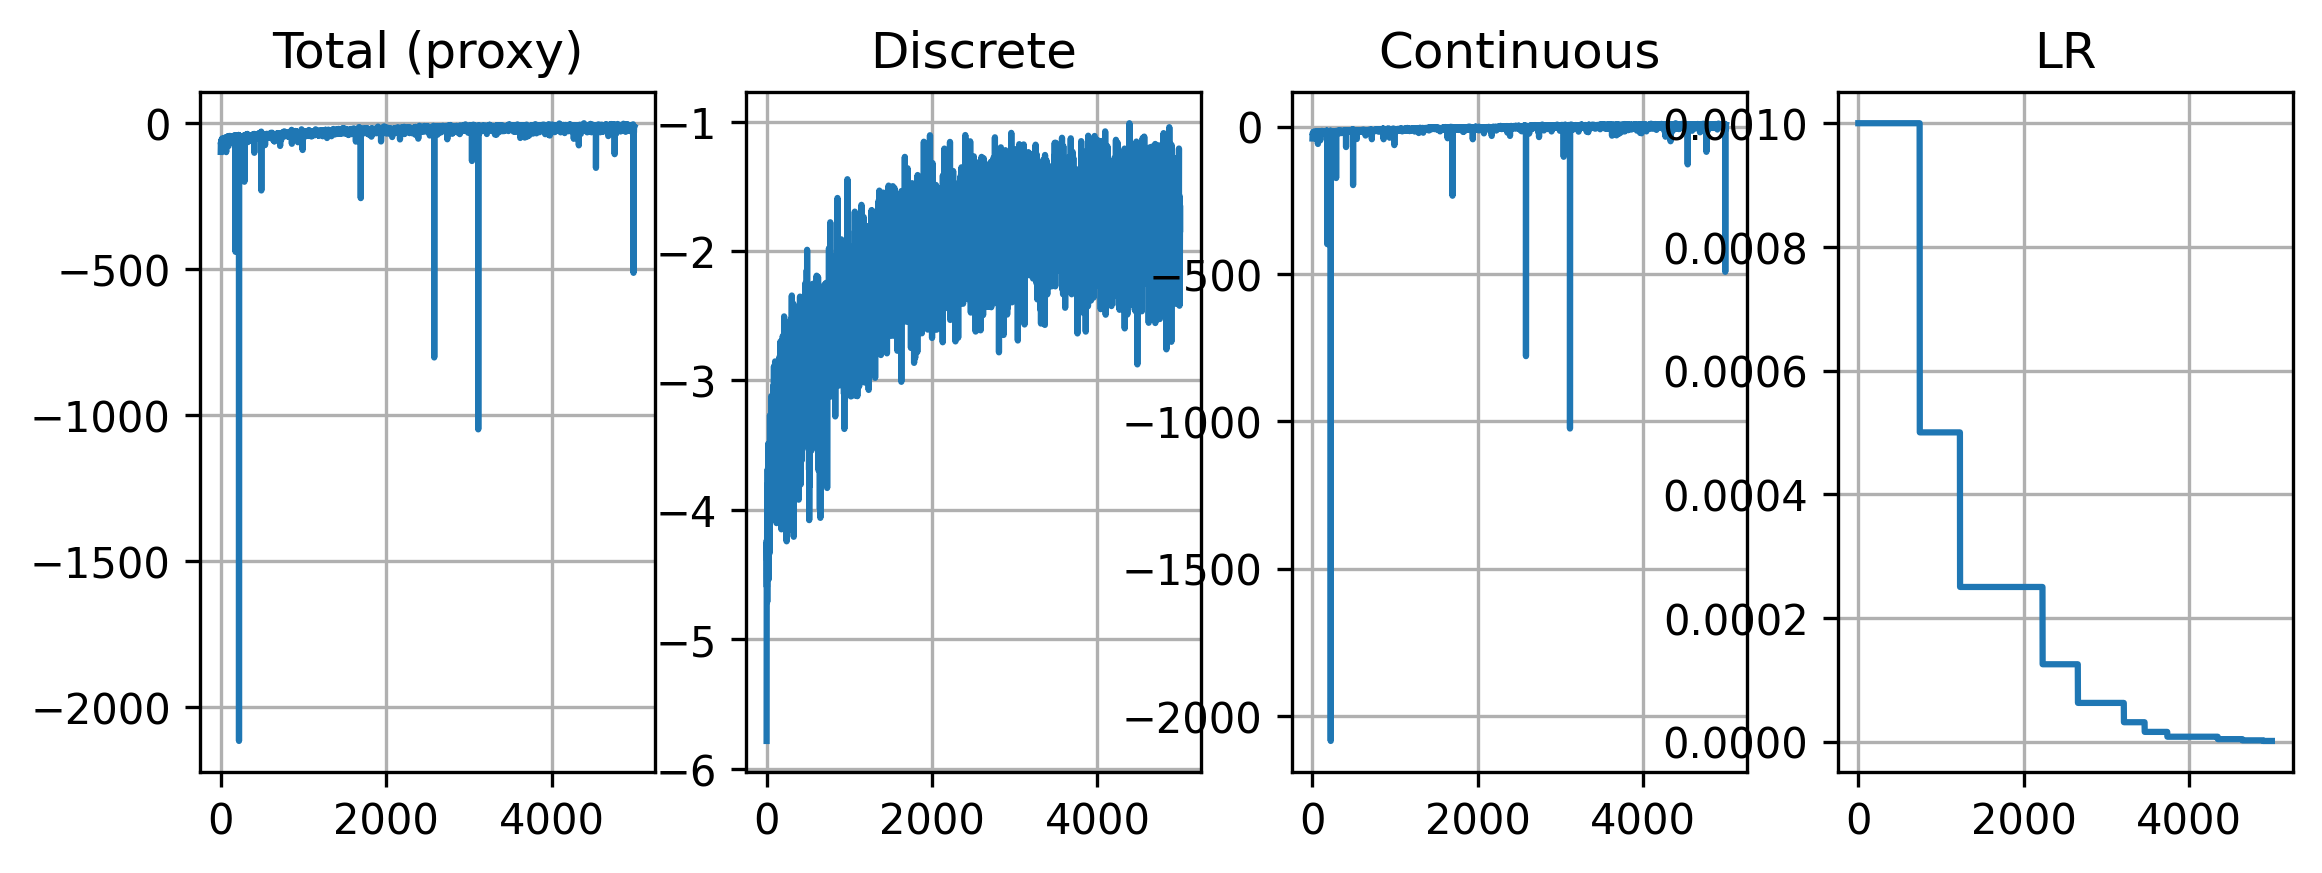

In [16]:
def set_reasonable_bounds(hist, lb, ub):
    low = max(np.min(hist) - 1. , lb)
    high = min(np.max(hist) + 1., ub)
plt.figure(dpi=300).set_size_inches(9, 3)
plt.subplot(1, 4, 1)
plt.title("Total (proxy)")
plt.plot(total_objective_history)
set_reasonable_bounds(total_objective_history, -40, 100.)
plt.grid(True)
plt.subplot(1, 4, 2)
plt.title("Discrete")
plt.plot(discrete_score_history)
set_reasonable_bounds(discrete_score_history, -40., 100.)
plt.grid(True)
plt.subplot(1, 4, 3)
plt.title("Continuous")
plt.plot(continuous_score_history)
plt.grid(True)
set_reasonable_bounds(continuous_score_history, -40., 100)
plt.subplot(1, 4, 4)
plt.title("LR")
plt.plot(lr_history)
plt.grid(True)

Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  4
Entering example  5
Entering example  6
Entering example  7
Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  4
Entering example  5
Entering example  6
Entering example  7


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

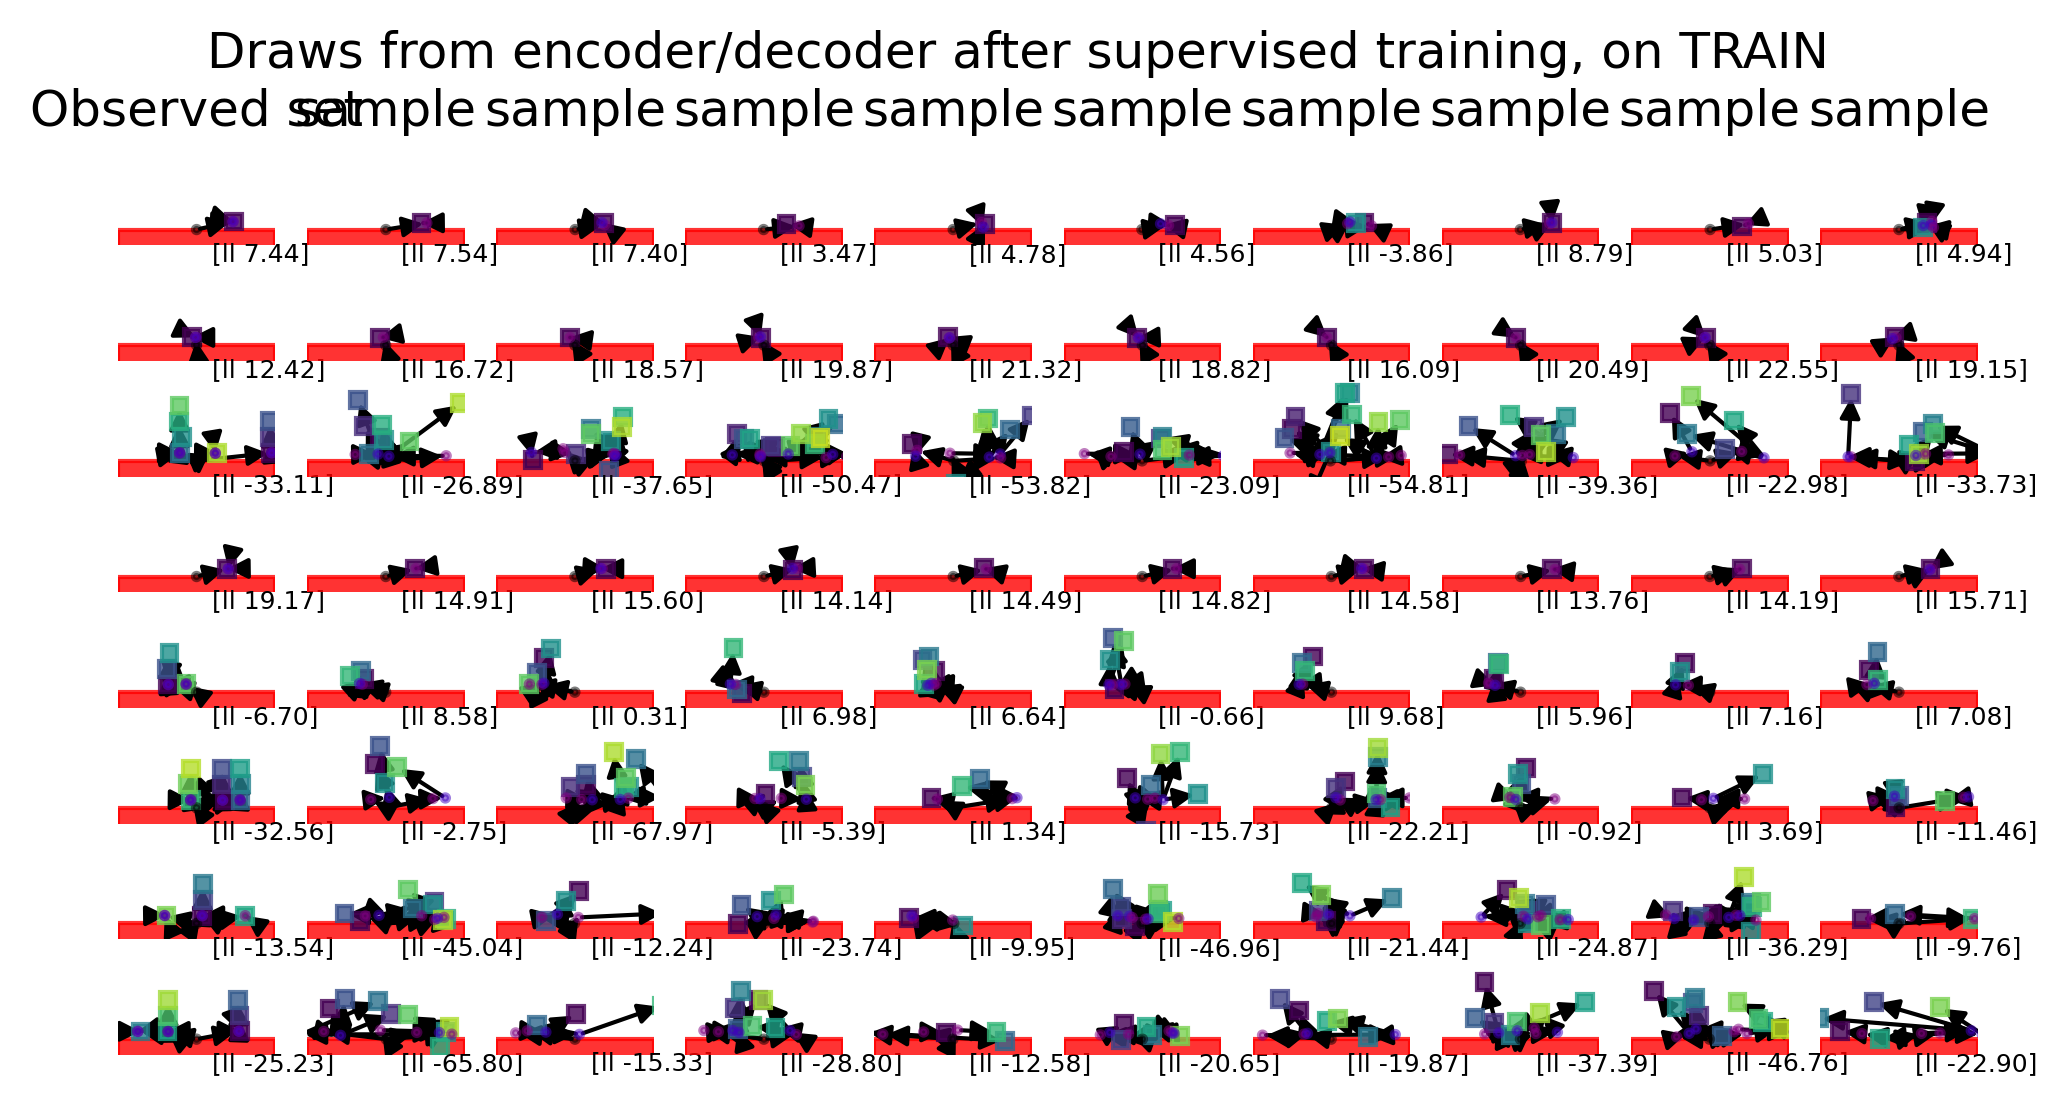

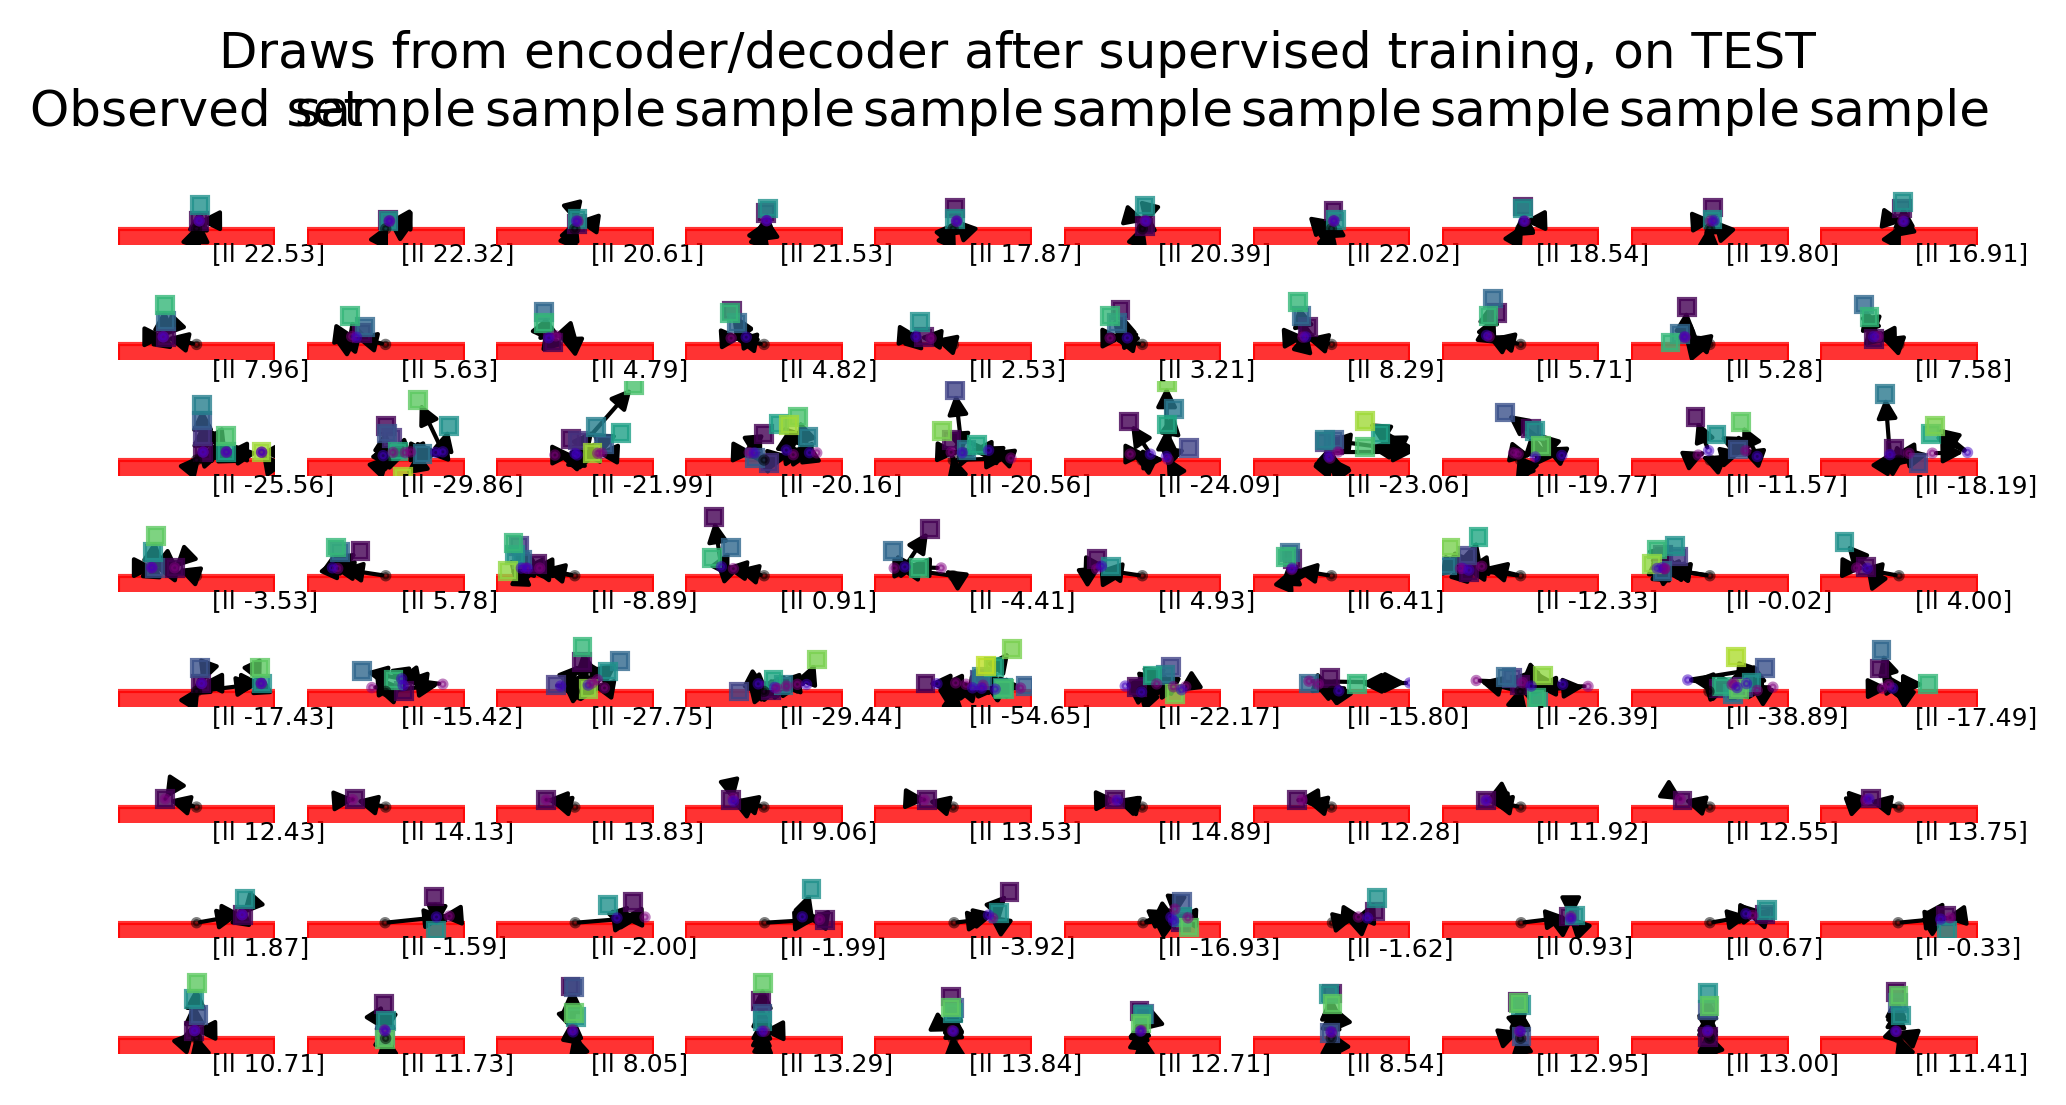

In [15]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 10
    N_height = 8
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        print("Entering example ", i)
        plt.subplot(N_height, N_width, i*N_width + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        
        # Score the test tree under its encoded vector
        density = encoder.score_tree_with_grammar_vector(full_trees[i], x, include_continuous=True)
        plt.text(x=1., y=-2., s="[ll %0.2f]" % density, fontsize=6)
        
        for j in range(1, N_width):
            k = i*N_width + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, _, _ = encoder.sample_tree_from_grammar_vector(x)
            proposal_density = encoder.score_tree_with_grammar_vector(sampled_tree, x, include_continuous=True)
            #box_k = 0
            #for node in sampled_tree.nodes:
            #    if isinstance(node, Box):
            #        node.xy = torch.tensor([0., box_k])
            #        box_k += 1
            #    else:
            #        node.xy = torch.zeros(2)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [ ]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
save_name = "encoder_supervised_gru_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
save_encoder_state(save_path)

In [ ]:
# Load output
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GRU")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 1:
    # Load encoder from saved run.
    weight_path = "saved_models/20210609/encoder_supervised_gru_43.1707.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [ ]:
# Training
from warmup_scheduler import GradualWarmupScheduler


N_EPOCHS = 5000
N_ITERS_PER_EPOCH = 25
N_SAMPLES_PER_ENCODING = 4
MIN_LL_SATURATION = -10000

restart_training = False

torch.manual_seed(43)

SETUP_TRAINING = False

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

if SETUP_TRAINING:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)
    mean_sampled_f_history = []
    mean_sampled_score_history = []
    total_objective_history = []
    epoch = 0

while epoch < N_EPOCHS:
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f, lr %f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective, 
            optimizer.param_groups[0]['lr']))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step(mean_objective)
    
    epoch += 1

unsupervised_training_finish_time = time.time()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

In [ ]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)